<a href="https://colab.research.google.com/github/o54ma-4l5h4r1f/ChessObjectsDetection/blob/Yolov4/yolov4_webcam-2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction


In this notebook, we implement [YOLOv4](https://blog.roboflow.com/training-yolov4-on-a-custom-dataset/) which is an object detection algorithm for our training.
<br><br>
Darknet is an open source artificial neural network framework written in C and CUDA
<br><br>
[What is Weight (Artificial Neural Network)?](https://deepai.org/machine-learning-glossary-and-terms/weight-artificial-neural-network)


# Let's Start Training 

## Configuring cuDNN on Colab for YOLOv4


In [ ]:
# CUDA: Let's check that Nvidia CUDA drivers are already pre-installed and which version is it.
!/usr/local/cuda/bin/nvcc --version

# Colab added cuDNN as an inherent install - so you don't have to do a thing - major win
!nvidia-smi

# This code ensures you have the correct architecture for your respective GPU
# If you command is not found, look through these GPUs, find the respective
# GPU and add them to the archTypes dictionary

import os
os.environ['GPU_TYPE'] = str(os.popen('nvidia-smi --query-gpu=name --format=csv,noheader').read())

def getGPUArch(argument):
  try:
    argument = argument.strip()
    # All Colab GPUs
    archTypes = {
        "Tesla V100-SXM2-16GB": "-gencode arch=compute_70,code=[sm_70,compute_70]",
        "Tesla K80": "-gencode arch=compute_37,code=sm_37",
        "Tesla T4": "-gencode arch=compute_75,code=[sm_75,compute_75]",
        "Tesla P40": "-gencode arch=compute_61,code=sm_61",
        "Tesla P4": "-gencode arch=compute_61,code=sm_61",
        "Tesla P100-PCIE-16GB": "-gencode arch=compute_60,code=sm_60"

      }
    return archTypes[argument]
  except KeyError:
    return "GPU must be added to GPU Commands"
os.environ['ARCH_VALUE'] = getGPUArch(os.environ['GPU_TYPE'])

print("GPU Type: " + os.environ['GPU_TYPE'])
print("ARCH Value: " + os.environ['ARCH_VALUE'])

## Installing Darknet for YOLOv4 on Colab

In [ ]:
%cd /content/
%rm -rf darknet
!git clone https://github.com/roboflow-ai/darknet.git
%cd /content/darknet/

#colab occasionally shifts dependencies around, at the time of authorship, This Makefile works for building Darknet on Colab
%rm Makefile
!wget https://raw.githubusercontent.com/o54ma-4l5h4r1f/ChessObjectsDetection/Yolov4/Makefile
!sed -i 's/OPENCV=0/OPENCV=1/g' Makefile
!sed -i 's/GPU=0/GPU=1/g' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/g' Makefile
!sed -i "s/ARCH= -gencode arch=compute_37,code=sm_37/ARCH= ${ARCH_VALUE}/g" Makefile

In [ ]:
!make

## Installing Yolov4 ConvNet weights

In [ ]:
#download the newly released yolov4 ConvNet weights
%cd /content/darknet
!wget https://github.com/AlexeyAB/darknet/releases/download/darknet_yolo_v3_optimal/yolov4.conv.137

## Set up Custom Dataset for YOLOv4

In [ ]:
#follow the link below to get your download code from from Roboflow
!pip install -q roboflow
from roboflow import Roboflow
rf = Roboflow(model_format="darknet", notebook="roboflow-yolov4")

%cd /content/

rf = Roboflow(api_key="zULeeVmmrvMu6rp8LSoQ")
project = rf.workspace("osama-alsharif").project("chessobjectsdetection-ggjgw")
dataset = project.version(1).download("darknet")

##===================================================================================================

#Set up training file directories for custom dataset
%cd /content/darknet/
%cp {dataset.location}/train/_darknet.labels data/obj.names
%mkdir data/obj
#copy image and labels
%cp {dataset.location}/train/*.jpg data/obj/
%cp {dataset.location}/valid/*.jpg data/obj/

%cp {dataset.location}/train/*.txt data/obj/
%cp {dataset.location}/valid/*.txt data/obj/

with open('data/obj.data', 'w') as out:
  out.write('classes = 5\n')
  out.write('train = data/train.txt\n')
  out.write('valid = data/valid.txt\n')
  out.write('names = data/obj.names\n')
  out.write('backup = backup/')

#write train file (just the image list)
import os

with open('data/train.txt', 'w') as out:
  for img in [f for f in os.listdir(dataset.location + '/train') if f.endswith('jpg')]:
    out.write('data/obj/' + img + '\n')

#write the valid file (just the image list)
import os

with open('data/valid.txt', 'w') as out:
  for img in [f for f in os.listdir(dataset.location + '/valid') if f.endswith('jpg')]:
    out.write('data/obj/' + img + '\n')

## Write Custom Training Config for YOLOv4

In [ ]:
#we build config dynamically based on number of classes
#we build iteratively from base config files. This is the same file shape as cfg/yolo-obj.cfg
def file_len(fname):
  with open(fname) as f:
    for i, l in enumerate(f):
      pass
  return i + 1

num_classes = file_len(dataset.location + '/train/_darknet.labels')
print("writing config for a custom YOLOv4 detector detecting number of classes: " + str(num_classes))

#Instructions from the darknet repo
#change line max_batches to (classes*2000 but not less than number of training images, and not less than 6000), f.e. max_batches=6000 if you train for 3 classes
#change line steps to 80% and 90% of max_batches, f.e. steps=4800,5400
if os.path.exists('./cfg/custom-yolov4-detector.cfg'): os.remove('./cfg/custom-yolov4-detector.cfg')


with open('./cfg/custom-yolov4-detector.cfg', 'a') as f:
  f.write('[net]' + '\n')
  f.write('batch=64' + '\n')
  #####smaller subdivisions help the GPU run faster. 12 is optimal, but you might need to change to 24,36,64####
  f.write('subdivisions=24' + '\n')
  f.write('width=416' + '\n')
  f.write('height=416' + '\n')
  f.write('channels=3' + '\n')
  f.write('momentum=0.949' + '\n')
  f.write('decay=0.0005' + '\n')
  f.write('angle=0' + '\n')
  f.write('saturation = 1.5' + '\n')
  f.write('exposure = 1.5' + '\n')
  f.write('hue = .1' + '\n')
  f.write('\n')
  f.write('learning_rate=0.001' + '\n')
  f.write('burn_in=1000' + '\n')
  ######you can adjust up and down to change training time#####
  ##Darknet does iterations with batches, not epochs####
  # max_batches = num_classes*2000
  max_batches = 500
  f.write('max_batches=' + str(max_batches) + '\n')
  f.write('policy=steps' + '\n')
  steps1 = .8 * max_batches
  steps2 = .9 * max_batches
  f.write('steps='+str(steps1)+','+str(steps2) + '\n')

#Instructions from the darknet repo
#change line classes=80 to your number of objects in each of 3 [yolo]-layers:
#change [filters=255] to filters=(classes + 5)x3 in the 3 [convolutional] before each [yolo] layer, keep in mind that it only has to be the last [convolutional] before each of the [yolo] layers.

  with open('cfg/yolov4-custom2.cfg', 'r') as f2:
    content = f2.readlines()
    for line in content:
      f.write(line)    
    num_filters = (num_classes + 5) * 3
    f.write('filters='+str(num_filters) + '\n')
    f.write('activation=linear')
    f.write('\n')
    f.write('\n')
    f.write('[yolo]' + '\n')
    f.write('mask = 0,1,2' + '\n')
    f.write('anchors = 12, 16, 19, 36, 40, 28, 36, 75, 76, 55, 72, 146, 142, 110, 192, 243, 459, 401' + '\n')
    f.write('classes=' + str(num_classes) + '\n')

  with open('cfg/yolov4-custom3.cfg', 'r') as f3:
    content = f3.readlines()
    for line in content:
      f.write(line)    
    num_filters = (num_classes + 5) * 3
    f.write('filters='+str(num_filters) + '\n')
    f.write('activation=linear')
    f.write('\n')
    f.write('\n')
    f.write('[yolo]' + '\n')
    f.write('mask = 3,4,5' + '\n')
    f.write('anchors = 12, 16, 19, 36, 40, 28, 36, 75, 76, 55, 72, 146, 142, 110, 192, 243, 459, 401' + '\n')
    f.write('classes=' + str(num_classes) + '\n')

  with open('cfg/yolov4-custom4.cfg', 'r') as f4:
    content = f4.readlines()
    for line in content:
      f.write(line)    
    num_filters = (num_classes + 5) * 3
    f.write('filters='+str(num_filters) + '\n')
    f.write('activation=linear')
    f.write('\n')
    f.write('\n')
    f.write('[yolo]' + '\n')
    f.write('mask = 6,7,8' + '\n')
    f.write('anchors = 12, 16, 19, 36, 40, 28, 36, 75, 76, 55, 72, 146, 142, 110, 192, 243, 459, 401' + '\n')
    f.write('classes=' + str(num_classes) + '\n')
    
  with open('cfg/yolov4-custom5.cfg', 'r') as f5:
    content = f5.readlines()
    for line in content:
      f.write(line)

print("file is written!")

In [ ]:
#here is the file that was just written. 
#you may consider adjusting certain things

#like the number of subdivisions 64 runs faster but Colab GPU may not be big enough
#if Colab GPU memory is too small, you will need to adjust subdivisions to 16
from google.colab import files
files.download('/content/darknet/cfg/custom-yolov4-detector.cfg')
files.download('/content/darknet/data/valid.txt')
files.download('/content/darknet/data/train.txt')
files.download('/content/darknet/data/obj.data')
files.download('/content/darknet/data/obj.names')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Train Custom YOLOv4 Detector

In [ ]:
!./darknet detector train data/obj.data cfg/custom-yolov4-detector.cfg yolov4.conv.137 -dont_show -map
files.download('/content/darknet/backup/custom-yolov4-detector_best.weights')

## Testing our training result

In [ ]:
#define utility function
def imShow(path):
  import cv2
  import matplotlib.pyplot as plt
  %matplotlib inline

  image = cv2.imread(path)
  height, width = image.shape[:2]
  resized_image = cv2.resize(image,(3*width, 3*height), interpolation = cv2.INTER_CUBIC)

  fig = plt.gcf()
  fig.set_size_inches(18, 10)
  plt.axis("off")
  #plt.rcParams['figure.figsize'] = [10, 5]
  plt.imshow(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))
  plt.show()

In [ ]:
#check if weigths have saved yet
#backup houses the last weights for our detector
#(file yolo-obj_last.weights will be saved to the build\darknet\x64\backup\ for each 100 iterations)
#(file yolo-obj_xxxx.weights will be saved to the build\darknet\x64\backup\ for each 1000 iterations)
#After training is complete - get result yolo-obj_final.weights from path build\darknet\x64\bac
!ls backup
#if it is empty you haven't trained for long enough yet, you need to train for at least 100 iterations

In [ ]:
#coco.names is hardcoded somewhere in the detector
%cd /content/darknet/
%cp data/obj.names data/coco.names

/content/darknet


In [ ]:
#/test has images that we can test our detector on
test_images = [f for f in os.listdir('/content/ChessObjectsDetection-1/test') if f.endswith('.jpg')]
import random
img_path = "/content/ChessObjectsDetection-1/test" + random.choice(test_images);

#test out our detector!
!./darknet detect /content/tmp/custom-yolov4-detector.cfg /content/tmp/custom-yolov4-detector_best.weights {img_path} -dont-show
imShow('/content/darknet/predictions.jpg')

----- 
<br><br><br><br><br><br><br><br>

-----

# Real Time Object Detection 

## import dependencies

In [2]:

from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from google.colab.patches import cv2_imshow
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import html
import time
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# take the needed file from the training
%cd /content/
# !git clone https://github.com/o54ma-4l5h4r1f/tmp.git
from google.colab import drive
drive.mount('/content/drive')

/content
Mounted at /content/drive


## Cloning and Setting Up Darknet for YOLOv4


In [4]:
# clone darknet repo
%cd /content/
!git clone https://github.com/AlexeyAB/darknet

/content
Cloning into 'darknet'...
remote: Enumerating objects: 15395, done.
remote: Total 15395 (delta 0), reused 0 (delta 0), pack-reused 15395
Receiving objects: 100% (15395/15395), 13.99 MiB | 18.09 MiB/s, done.
Resolving deltas: 100% (10354/10354), done.


In [5]:
# change makefile to have GPU, OPENCV and LIBSO enabled
%cd darknet
!sed -i 's/OPENCV=0/OPENCV=1/' Makefile
!sed -i 's/GPU=0/GPU=1/' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/' Makefile
!sed -i 's/CUDNN_HALF=0/CUDNN_HALF=1/' Makefile
!sed -i 's/LIBSO=0/LIBSO=1/' Makefile

/content/darknet


In [6]:
# make darknet (builds darknet so that you can then use the darknet.py file and have its dependencies)
!make

mkdir -p ./obj/
mkdir -p backup
chmod +x *.sh
g++ -std=c++11 -std=c++11 -Iinclude/ -I3rdparty/stb/include -DOPENCV `pkg-config --cflags opencv4 2> /dev/null || pkg-config --cflags opencv` -DGPU -I/usr/local/cuda/include/ -DCUDNN -DCUDNN_HALF -Wall -Wfatal-errors -Wno-unused-result -Wno-unknown-pragmas -fPIC -Ofast -DOPENCV -DGPU -DCUDNN -I/usr/local/cudnn/include -DCUDNN_HALF -fPIC -c ./src/image_opencv.cpp -o obj/image_opencv.o
./src/image_opencv.cpp: In function ‘void draw_detections_cv_v3(void**, detection*, int, float, char**, image**, int, int)’:
./src/image_opencv.cpp:946:23: warning: variable ‘rgb’ set but not used [-Wunused-but-set-variable]
                 float rgb[3];
                       ^~~
./src/image_opencv.cpp: In function ‘void draw_train_loss(char*, void**, int, float, float, int, int, float, int, char*, float, int, int, double)’:
./src/image_opencv.cpp:1147:13: warning: this ‘if’ clause does not guard... [-Wmisleading-indentation]
             if (iteration_old ==

In [ ]:
# get bthe scaled yolov4 weights file that is pre-trained to detect 80 classes (objects) from shared google drive
# !wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1V3vsIaxAlGWvK4Aar9bAiK5U0QFttKwq' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1V3vsIaxAlGWvK4Aar9bAiK5U0QFttKwq" -O yolov4-csp.weights && rm -rf /tmp/cookies.txt

In [7]:
!pip install -q roboflow
from roboflow import Roboflow
rf = Roboflow(model_format="darknet", notebook="roboflow-yolov4")

%cd /content/

rf = Roboflow(api_key="zULeeVmmrvMu6rp8LSoQ")
project = rf.workspace("osama-alsharif").project("chessobjectsdetection-ggjgw")
dataset = project.version(1).download("darknet")

     |████████████████████████████████| 1.1 MB 8.0 MB/s 
     |████████████████████████████████| 145 kB 47.6 MB/s 
     |████████████████████████████████| 67 kB 5.4 MB/s 
     |████████████████████████████████| 596 kB 43.7 MB/s 
     |████████████████████████████████| 178 kB 49.7 MB/s 
     |████████████████████████████████| 138 kB 43.5 MB/s 
     |████████████████████████████████| 63 kB 1.6 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.
upload and label your dataset, and get an API KEY here: https://app.roboflow.com/?model=darknet&ref=roboflow-yolov4
/content
loading

Extracting Dataset Version Zip to ChessObjectsDetection-1 in darknet:: 100%|██████████| 72/72 [00:00<00:00, 1278.40it/s]


In [8]:
#Set up training file directories for custom dataset
%cd /content/darknet/
%cp {dataset.location}/train/_darknet.labels data/obj.names
%mkdir data/obj
#copy image and labels
%cp {dataset.location}/train/*.jpg data/obj/
%cp {dataset.location}/valid/*.jpg data/obj/

%cp {dataset.location}/train/*.txt data/obj/
%cp {dataset.location}/valid/*.txt data/obj/

with open('data/obj.data', 'w') as out:
  out.write('classes = 5\n')
  out.write('train = data/train.txt\n')
  out.write('valid = data/valid.txt\n')
  out.write('names = data/obj.names\n')
  out.write('backup = backup/')

#write train file (just the image list)
import os

with open('data/train.txt', 'w') as out:
  for img in [f for f in os.listdir(dataset.location + '/train') if f.endswith('jpg')]:
    out.write('data/obj/' + img + '\n')

#write the valid file (just the image list)
import os

with open('data/valid.txt', 'w') as out:
  for img in [f for f in os.listdir(dataset.location + '/valid') if f.endswith('jpg')]:
    out.write('data/obj/' + img + '\n')

/content/darknet


## Darknet for Python
In order to utilize YOLOv4 with Python code we will use some of the pre-built functions found within darknet.py by importing the functions into our workstation. Feel free to checkout the darknet.py file to see the function definitions in detail! 

In [52]:
%cd /content/darknet
# import darknet functions to perform object detections
from darknet import *
# load in our YOLOv4 architecture network
network, class_names, class_colors = load_network("/content/drive/MyDrive/DetectionData/custom-yolov4-detector.cfg", "/content/drive/MyDrive/DetectionData/obj.data", "/content/drive/MyDrive/DetectionData/custom-yolov4-detector_best.weights")
width = network_width(network)
height = network_height(network)

/content/darknet


In [10]:
print(width, height)

416 416


In [153]:
# darknet helper function to run detection on image
def darknet_helper(img, width, height):
  darknet_image = make_image(width, height, 3)
  img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img_resized = cv2.resize(img_rgb, (width, height),
                              interpolation=cv2.INTER_LINEAR)

  # get image ratios to convert bounding boxes to proper size
  img_height, img_width, _ = img.shape
  width_ratio = img_width/width
  height_ratio = img_height/height

  # run model on darknet style image to get detections
  copy_image_from_bytes(darknet_image, img_resized.tobytes())
  detections = detect_image(network, class_names, darknet_image)
  free_image(darknet_image)

  # x, y, w, h = bbox2points(bbox)
  # x, y, w, h = int(x * width_ratio), int(y * height_ratio), int(w * width_ratio), int(h * height_ratio)
  # print(detections[1][2])
  # x, y, w, h = bbox2points(detections[1][2])
  # x, y, w, h = int(x * width_ratio), int(y * height_ratio), int(w * width_ratio), int(h * height_ratio)

  # deldetections[1][2]  print(detections[1][2])

  return detections, width_ratio, height_ratio

## YOLOv4 Example on Test Image
Let's make sure our model has successfully been loaded and that we can make detections properly on a test image.

In [148]:
print(detections,'\n', width_ratio,'\n', height_ratio)

[('Pawn', '66.67', (273.8069763183594, 213.98045349121094, 36.631290435791016, 84.84817504882812)), ('Rook', '72.15', (271.04730224609375, 181.62632751464844, 37.558624267578125, 58.02311325073242)), ('Knight', '77.53', (222.79185485839844, 42.674720764160156, 32.42283630371094, 54.01557922363281)), ('Pawn', '79.32', (197.58824157714844, 273.790283203125, 31.797439575195312, 50.93129348754883)), ('Bishop', '84.73', (196.00941467285156, 101.02670288085938, 25.71282958984375, 81.03799438476562)), ('Knight', '89.25', (285.3716125488281, 60.867515563964844, 33.644126892089844, 61.48755645751953)), ('Bishop', '93.26', (274.8143005371094, 215.12322998046875, 47.216835021972656, 73.80626678466797)), ('Pawn', '96.45', (162.44000244140625, 116.66067504882812, 26.638147354125977, 55.22165298461914)), ('Pawn', '97.74', (227.88644409179688, 150.80355834960938, 30.919736862182617, 53.282958984375)), ('Bishop', '98.88', (195.5451202392578, 215.53057861328125, 45.175384521484375, 77.31251525878906)),

In [154]:
def Detect(detections, width_ratio, height_ratio, image):
  for label, confidence, bbox in detections:
    x, y, w, h = bbox2points(bbox)
    x, y, w, h = int(x * width_ratio), int(y * height_ratio), int(w * width_ratio), int(h * height_ratio)
    # x, y, w, h = coordinates

    cv2.rectangle(image, (x, y), (w, h), class_colors[label], 2)
    cv2.putText(image, "{} [{:.2f}]".format(label, float(confidence)),(x, y - 5), cv2.FONT_HERSHEY_COMPLEX_SMALL, 0.5,class_colors[label], 1)
      
  cv2_imshow(image)

/content/ChessObjectsDetection-1/test/19_jpg.rf.bbccbf65104cf6229b9acbc826788bb2.jpg


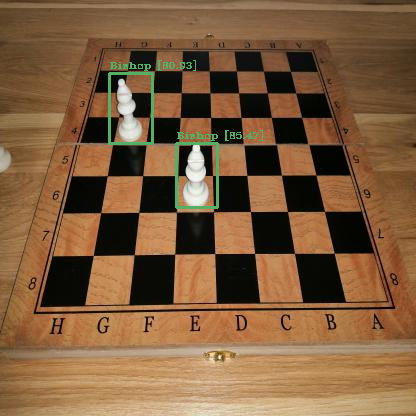

/content/ChessObjectsDetection-1/test/5_jpg.rf.18dd75b4224e0c5d5593cbcd9995408d.jpg


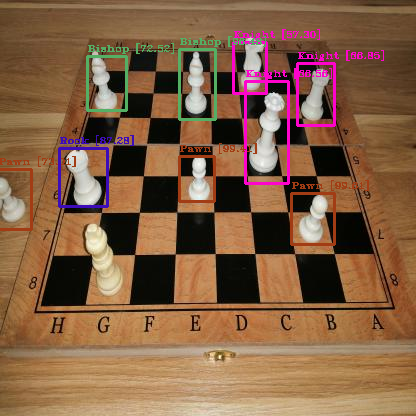

/content/ChessObjectsDetection-1/test/12_jpg.rf.5740defaf05725edd358953ec9fedce3.jpg


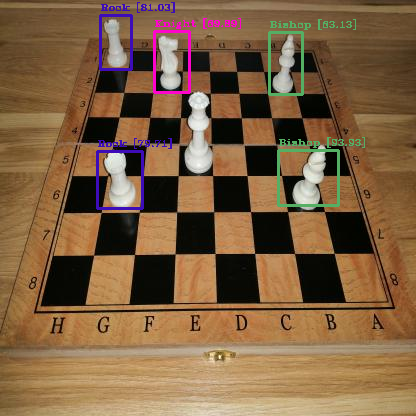

/content/ChessObjectsDetection-1/test/31_jpg.rf.1e02c005794a96b96167a6bee53eb976.jpg


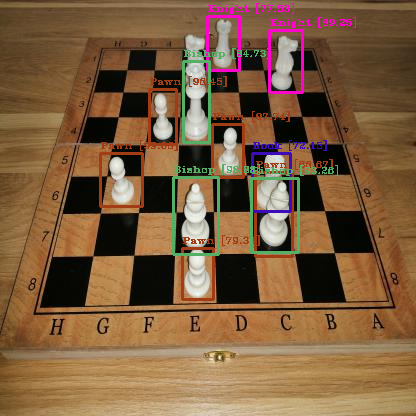

In [155]:
# run test on person.jpg image that comes with repository
folder = '/content/ChessObjectsDetection-1/test/'

for I in os.listdir(folder):
  if I.endswith('.jpg'):
    print(folder + I) 

    image = cv2.imread(folder + I)
    detections, width_ratio, height_ratio = darknet_helper(image, width, height)
    Detect(detections, width_ratio, height_ratio, image)
  

# NMS

In [88]:
import torch
from torchvision.ops import nms

In [393]:
image = cv2.imread('/content/ChessObjectsDetection-1/test/31_jpg.rf.1e02c005794a96b96167a6bee53eb976.jpg')
detections, width_ratio, height_ratio = darknet_helper(image, width, height)

B = []
S = []
L = []
for label, confidence, bbox in detections:
  x, y, w, h = bbox2points(bbox)
  x, y, w, h = int(x * width_ratio), int(y * height_ratio), int(w * width_ratio), int(h * height_ratio)
  B.append([x, y, w, h])
  S.append(float(confidence))
  L.append(label)

# print(B)
# print(S)
# print(L)

boxes = torch.tensor(B, dtype=torch.float32)
scores = torch.tensor(S, dtype=torch.float32)
NMS = nms(boxes = boxes, scores = scores, iou_threshold=0.3) # 0.3 
# print("NMS = ", int(NMS[0]))
  

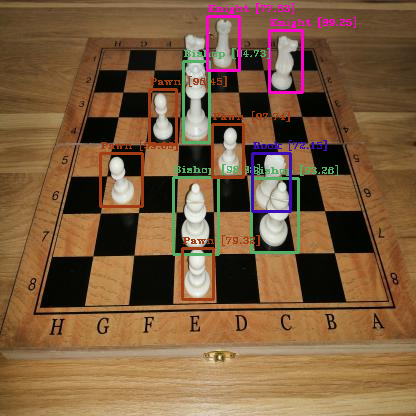

In [394]:
# for label, confidence, bbox in detections:
  # x, y, w, h = bbox2points(bbox)
  # x, y, w, h = int(x * width_ratio), int(y * height_ratio), int(w * width_ratio), int(h * height_ratio)

for i in NMS: 
  x, y, w, h = B[i]
  confidence = S[i]
  label = L[i]

  cv2.rectangle(image, (x, y), (w, h), class_colors[label], 2)
  cv2.putText(image, "{} [{:.2f}]".format(label, float(confidence)),(x, y - 5), cv2.FONT_HERSHEY_COMPLEX_SMALL, 0.5,class_colors[label], 1)
      
cv2_imshow(image)


### Grid Design

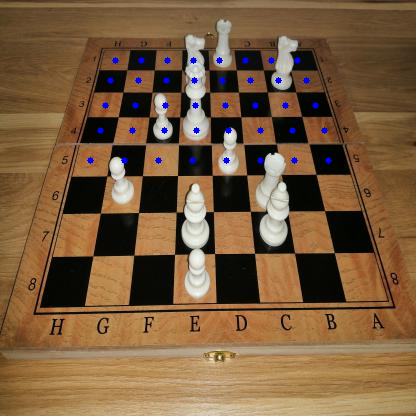

In [236]:
image = cv2.imread('/content/ChessObjectsDetection-1/test/31_jpg.rf.1e02c005794a96b96167a6bee53eb976.jpg')

_1 = 60
H1 = 115
spacing = 26
D1 = [(H1,_1),(H1+spacing*1,_1),(H1+spacing*2,_1),(H1+spacing*3,_1),(H1+spacing*4,_1),(H1+spacing*5,_1), (H1+spacing*6,_1),(H1+spacing*7,_1)]

for dot in D1:
  cv2.circle(image, dot, 3, (255,0,0), thickness=cv2.FILLED)

_2 = 80   # +20
H2 = 110  # -5 
spacing = 28
D2 = [(H2,_2),(H2+spacing*1,_2),(H2+spacing*2,_2),(H2+spacing*3,_2),(H2+spacing*4,_2), (H2+spacing*5,_2),(H2+spacing*6,_2),(H2+spacing*7,_2)]

for dot in D2:
  cv2.circle(image, dot, 3, (255,0,0), thickness=cv2.FILLED)


_3 = 105  # +25
H3 = 105  # -5 
spacing = 30
D3 = [(H3,_3),(H3+spacing*1,_3),(H3+spacing*2,_3),(H3+spacing*3,_3),(H3+spacing*4,_3),(H3+spacing*5,_3),(H3+spacing*6,_3),(H3+spacing*7,_3)]

for dot in D3:
  cv2.circle(image, dot, 3, (255,0,0), thickness=cv2.FILLED)


_4 = 130  # +25
H4 = 100  # -5 
spacing = 32
D4 = [(H4,_4),(H4+spacing*1,_4),(H4+spacing*2,_4),(H4+spacing*3,_4),(H4+spacing*4,_4),(H4+spacing*5,_4),(H4+spacing*6,_4),(H4+spacing*7,_4)]

for dot in D4:
  cv2.circle(image, dot, 3, (255,0,0), thickness=cv2.FILLED)



_5 = 160
H5 = 90
spacing = 34
D5 = [(H5,_5),(H5+spacing*1,_5),(H5+spacing*2,_5),(H5+spacing*3,_5),(H5+spacing*4,_5),(H5+spacing*5,_5),(H5+spacing*6,_5),(H5+spacing*7,_5)]

for dot in D5:
  cv2.circle(image, dot, 3, (255,0,0), thickness=cv2.FILLED)

# 91,160
# 85,194
# 75,235
# 66,281




cv2_imshow(image)




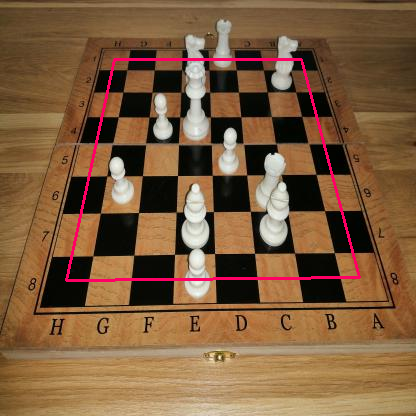

In [243]:
image = cv2.imread('/content/ChessObjectsDetection-1/test/31_jpg.rf.1e02c005794a96b96167a6bee53eb976.jpg')

# dealing with Fisheye Effect

# adjastable ==> we will try to make the user controle them 
H1 = (114,59)
A1 = (301,59)
A8 = (359,277)
H8 = (66,280)

MHL1 = [H1, A1]
MHL2 = [H8, A8]
MVL1 = [H1, H8]
MVL2 = [A1, A8]


cv2.line(image, MHL1[0], MHL1[1], (100, 0, 255), thickness=2)
cv2.line(image, MHL2[0], MHL2[1], (100, 0, 255), thickness=2)
cv2.line(image, MVL1[0], MVL1[1], (100, 0, 255), thickness=2)
cv2.line(image, MVL2[0], MVL2[1], (100, 0, 255), thickness=2)


cv2_imshow(image)

[(114, 59), (141, 59), (168, 59), (195, 59), (222, 59), (249, 59), (276, 59), (303, 59)]
[(66, 280), (108, 280), (150, 280), (192, 280), (234, 280), (276, 280), (318, 280), (360, 280)]


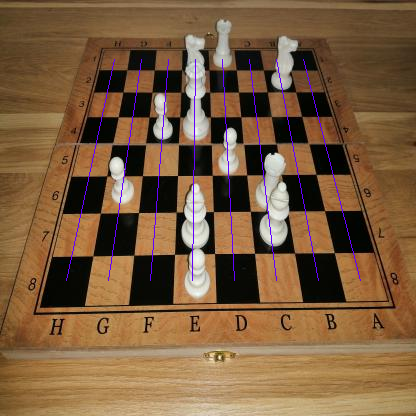

7
32
0
5
5
5
6
6
6
7
[(114, 59), (109, 81), (104, 104), (98, 131), (92, 161), (84, 195), (76, 232), (65, 283)]
8
31
[(301, 59), (307, 81), (312, 102), (319, 129), (327, 158), (335, 191), (344, 226), (357, 276)]


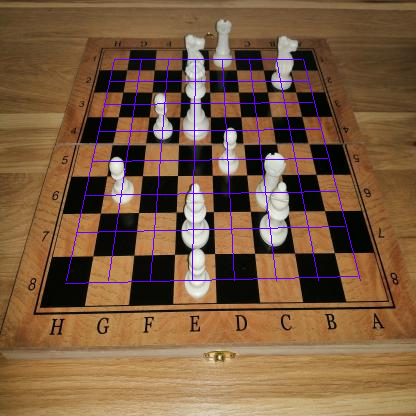

In [374]:
'''
split the  MHLs into 8 equal lines
'''

# MHL[edgePoint][X or Y]

image = cv2.imread('/content/ChessObjectsDetection-1/test/31_jpg.rf.1e02c005794a96b96167a6bee53eb976.jpg')

# Space between each adjacant lines
Spaces = round((abs(MHL1[0][0] - MHL1[1][0]))/7)
MHL1Points = []
for i in range(0,8):
  MHL1Points.append((MHL1[0][0] + Spaces*i, MHL1[0][1]))

print(MHL1Points)

Spaces = round((abs(MHL2[0][0] - MHL2[1][0]))/7)
MHL2Points = []
for i in range(0,8):
  MHL2Points.append((MHL2[0][0] + Spaces*i, MHL2[0][1]))  

print(MHL2Points)

# connects points between the main horizontal lines
VL = []
for i in range(len(MHL1Points)):
  cv2.line(image, MHL1Points[i], MHL2Points[i], (255, 0, 100), thickness=1)
  VL.append([MHL1Points[i], MHL2Points[i]])

cv2_imshow(image)


'''
split the  MVLs into 8 equal lines
'''
Ratios = [0, 0.7, 0.7, 0.75, 0.8, 0.85, 0.9, 1]
# Space between each adjacant lines 
# Notice the lines are not perfectly vertical 
SpacesX = round((abs(MVL1[0][0] - MVL1[1][0]))/7); print(SpacesX)
SpacesY = round((abs(MVL1[0][1] - MVL1[1][1]))/7); print(SpacesY)
MVL1Points = []
for i in range(0,8):
  print(round(SpacesX*Ratios[i]))
  MVL1Points.append((MVL1[0][0] - round(SpacesX*i*Ratios[i]), MVL1[0][1] + round(SpacesY*i*Ratios[i])))

print(MVL1Points)

SpacesX = round((abs(MVL2[0][0] - MVL2[1][0]))/7); print(SpacesX)
SpacesY = round((abs(MVL2[0][1] - MVL2[1][1]))/7); print(SpacesY)
MVL2Points = []

for i in range(0,8):
  MVL2Points.append((MVL2[0][0] + round(SpacesX*i*Ratios[i]), MVL2[0][1] + round(SpacesY*i*Ratios[i])))

print(MVL2Points)


# connects points between the main vertical lines
HL = []
for i in range(len(MVL1Points)):
  cv2.line(image, MVL1Points[i], MVL2Points[i], (255, 0, 100), thickness=1)
  HL.append([MVL1Points[i], MVL2Points[i]])

cv2_imshow(image)

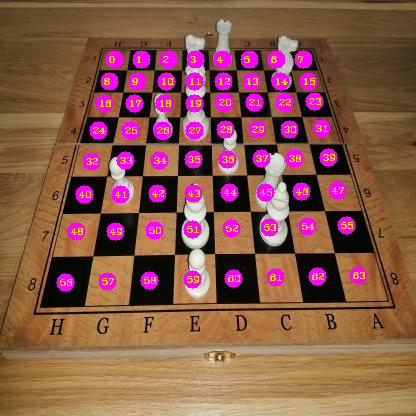

In [390]:
from numpy import *
def perp( a ) :
  b = empty_like(a)
  b[0] = -a[1]
  b[1] = a[0]
  return b

# line segment a given by endpoints a1, a2
# line segment b given by endpoints b1, b2
# return 
def seg_intersect(a1,a2, b1,b2) :
  da = a2-a1
  db = b2-b1
  dp = a1-b1
  dap = perp(da)
  denom = dot( dap, db)
  num = dot( dap, dp )
  # print(((num / denom.astype(int))*db + b1)[0])
  try:
    IntersectionPoint = (int(((num / denom.astype(int))*db + b1)[0]), int(((num / denom.astype(int))*db + b1)[1]))
    return IntersectionPoint
  except:
    return None

## ==========================================================================================
'''
p1 = array( (114, 59) )
p2 = array( (301, 59) )
p3 = array( (114, 59) )
p4 = array( (66, 280) ) 

print(seg_intersect( p1,p2, p3,p4))  # (114, 59)
'''

image = cv2.imread('/content/ChessObjectsDetection-1/test/31_jpg.rf.1e02c005794a96b96167a6bee53eb976.jpg')

IntersectionPoints = []
i = 0
for L1 in HL:  # L1 = [(114, 59), (301, 59)]
  for L2 in VL:  # L2 = [(114, 59), (66, 280)]
    P = seg_intersect(array(L1[0]),array(L1[1]),array(L2[0]),array(L2[1]))
    if P != None:
      # print(P)
      IntersectionPoints.append(P)
      cv2.circle(image, P, 9, (255,0,255), thickness=cv2.FILLED)
      cv2.putText(image, "{}".format(i),(P[0]-6,P[1]+3), cv2.FONT_HERSHEY_COMPLEX_SMALL, 0.5,(0,215,255), 1)
      i += 1

cv2_imshow(image)


# the index of the point, can indecate the object notation  
        


In [ ]:
ChessNotationMapping = {
    1, "H1"
}

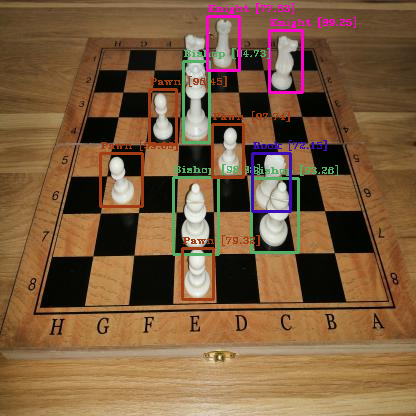

In [396]:
image = cv2.imread('/content/ChessObjectsDetection-1/test/31_jpg.rf.1e02c005794a96b96167a6bee53eb976.jpg')

for i in NMS: 
  x, y, w, h = B[i]
  confidence = S[i]
  label = L[i]

  cv2.rectangle(image, (x, y), (w, h), class_colors[label], 2)
  cv2.putText(image, "{} [{:.2f}]".format(label, float(confidence)),(x, y - 5), cv2.FONT_HERSHEY_COMPLEX_SMALL, 0.5,class_colors[label], 1)

  i = 0
  for x1, y1 in IntersectionPoints:
    if (x <= x1 or x1 <= x+w) and (y+round(h/2) <= y1 or y1 <= y+h):
      cv2.putText(image, "{}".format(i),(x1-6,y1+3), cv2.FONT_HERSHEY_COMPLEX_SMALL, 0.5,(0,215,255), 1)


cv2_imshow(image)

## Helper Functions
Here are a few helper functions defined that will be used to easily convert between different image types within our later steps.

In [115]:
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

## YOLOv4 on Wecam Images
Running YOLOv4 on images taken from webcam is fairly straight-forward. We will utilize code within Google Colab's **Code Snippets** that has a variety of useful code functions to perform various tasks.

We will be using the code snippet for **Camera Capture** which runs JavaScript code to utilize your computer's webcam. The code snippet will take a webcam photo, which we will then pass into our YOLOv4 model for object detection.

Below is a function to take the webcam picture using JavaScript and then run YOLOv4 on it.

In [ ]:
def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)

  # get photo data
  data = eval_js('takePhoto({})'.format(quality))
  # get OpenCV format image
  img = js_to_image(data) 
  
  # call our darknet helper on webcam image
  detections, width_ratio, height_ratio = darknet_helper(img, width, height)

  # loop through detections and draw them on webcam image
  for label, confidence, bbox in detections:
    left, top, right, bottom = bbox2points(bbox)
    left, top, right, bottom = int(left * width_ratio), int(top * height_ratio), int(right * width_ratio), int(bottom * height_ratio)
    cv2.rectangle(img, (left, top), (right, bottom), class_colors[label], 2)
    cv2.putText(img, "{} [{:.2f}]".format(label, float(confidence)),
                      (left, top - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5,
                      class_colors[label], 2)
  # save image
  cv2.imwrite(filename, img)

  return filename

In [ ]:
try:
  filename = take_photo('photo.jpg')
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

## YOLOv4 on Webcam Videos
![image.png](data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAoAAAAGkCAYAAAChGJSeAAAgAElEQVR4AeydB5jURBvHOXqTKlWkF+m9I0V6B5Xey8HBAQeCvfvZEHtBrAiiFAHpIh1pIihItaAg2LHS70_1v+fdc5ZsdpJNdtN298/zLMnmJpPJO/+Z+e07LdONU4jwgQ2gAWgAGoAGoAFoABqIHw1kQmbHT2Yjr5HX0AA0AA1AA9AANMAaAADCAwoPMDQADUAD0AA0AA3EmQYAgHGW4fjlh19+0AA0AA1AA9AANAAABADiVx80AA1AA9AANAANxJkGAIBxluH41YdffdAANAANQAPQADQAAAQA4lcfNAANQAPQADQADcSZBgCAcZbh+NWHX33QADQADUAD0AA0AAAEAOJXHzQADUAD0AA0AA3EmQYAgHGW4fjVh1990AA0AA1AA9AANAAABADiVx80AA1AA9AANAANxJkGAIBxluH41YdffdAANAANQAPQADQAAAQA4lcfNAANQAPQADQADcSZBgCAcZbh+NWHX33QADQADUAD0AA0AAAEAOJXHzQADUAD0AA0AA3EmQYAgHGW4fjVh1990AA0AA1AA9AANAAABADiVx80AA1AA9AANAANxJkGAIBxluH41YdffdAANAANQAPQADQAAAQA4lcfNAANQAPQADQADcSZBgCAcZbh+NWHX33QADQADUAD0AA0AAAEAOJXHzQADUAD0AA0AA3EmQYAgHGW4fjVh1990AA0AA1AA9AANAAABADiVx80AA1AA9AANAANxJkGAIBxluH41YdffdAANAANQAPQADQAAAQA4lcfNOBJDfSceMmT6ULDiYYTGoAGYkEDAEA0/mhkbdRA8xs/pGJlOgZ9rr1ukK7dqzS6K+gejqd+x7d89/WefFn695otnwyIVyucSFOJ8j2odLVhVLnBbdS463vUZcxPAfdrVXKV6k+VPl/Eqz7Wbfeabrzdxv1Jtdu8QCUr9qZceUtR5iw5KVOmTJSQORvlzFOcipbpQNWaP0KdRp/UjUcrvbLrHYZ/RWznwiVbUPachSkhIQslZM5KOXIVocIlm1OFuinUrNca6jUpzf/MinUnm3pvpR2uqdzXH88Ng/Zpx1O2M11T6WYqW2M01bh+BrXs+xFxPsreQVyr33GOdnwS/VWoM1E3PtZB/iJ1KH+R2tJP1Sb3697P6dJNU9lO1GPCOd04GnaZr/tO3cb9oXu/sA2OgDVoQK4BAKCNjT9EJxddPNmlc+L3lClTgg9mGGiUn06jTkgbsF4p6ZQ1e76AsOI+hgG2H4cR15RHhjmlfbXCKe9RnjMEMXzcMHh/QDzKOPmcAUl5X6hzBkZ1HPy99+R/qXqLxyhbjvyG4sucJTuVrzOBek68KI1P9gz1td4p/xCnh981VLr57wyEzXqt9j2vYPHGhu6RxcuQKdLS4sb1puLJmfca0oPoKo3uNhVfgaL1/WkRaVIe69wwUzc+hvJQUBoqTU16LNNNQ9HS7XXTYPTHivK9cI46GRq4ogEAIABQtxJGYblSWMK1RaESTaQNWb32r0tt36rvdml4ZaOrBXaRAqAAFwatWq2flaaP7WAFALJnjT1+4plmjgWLN6Ju437XTJ9eXpWuOtTkMxOow4ivfc9yCwCFbcrXTpa+cyjYEveLYygALHLtDSFt1LLPVmlahO1DpalszUTN+9k7mDlLDt00AAAjr5tEXuEYn7YEAAIANSthVArWVArcLSsaXuWxVOV+Uttf1+Q+afhytcb5w9sNgCKdtdu86H+mUg9WACB3p4rnhHPk7mtlmoycm/W8cboYhkTcbgMgp6dpz5X+9Ih0hYIttX31ALBr0m9B3lEZjIXqRg6VJvZqivSrj017LA+pDQCgNfWT2vb4Hj92BQACADUrYVQE1lQEHUcelzZm2XNd7esCVdu5UImm0vAtbtroz6tIAZC7NRkC8l1dU7f7lbtJ2w454H+uSKsMALNkzeXzDPLf1B81SLYesFv6jgwqPP6P4Y4BgyE5W44CmmF53KJIk5FjmWrDpXEVLd2OqjZ9iBi+eawee1sFNDXqssD/DO4ez5O/QsAnS9bc/rDiHrabOlzBYg398WiBKHtEKze4na69biBlzX5VULwcf/Fy3fzxiHfWgi32lKrzgr+XrTEqKA4RF3umxXuIY6kqA4KgkAGOu/DFfeqjVppEnHzksZDq+/h7uVpJQWlQ3sfnAEBr6ieZ/XEtPmwLAAQASitgVADWVgAMW+oGLKMB/CzA/t3H/xXU0HI4BjYeuybyJVIALFdzrD8uHsvVtOcKypmnhDSNJSvd5A8rns8QoX6fvAWrBIUT4dVHBjv1/fw9b8HK1HHktwHxsEeq8DXXS8MXKtksIKz6Oervsu74/FfXCoqDbXL9zZupTPUR1GtSatDflfHyRA/1u+h5t/heLQDkiQ8i7k6jvpPCOeeTCCOOWrAVDiQVK9s56H0YCgsUrRt0nYcriDSoj1ppUtqqWrOHpffnzlcm6FnK+/g8nHdTpxHfra3nYM/osicAEAAorYBRkK0tyDzRQd2A8fcaLaYH2L9xtyXScOrxUlYCoMjrtoM/9826VaeTvVndk88EpDMSAGSgknUp8mSZNgM/DXiOSFvnxB9J5mnjtPLfRLhQR/bCqd+PJ2d0Hn3KcBzqZ9gFgPwcnv2sTm+WbHmC0qoFW2YhiX+A8PhP9TPbDztKsi57vqa2h/guS1OBYg0C4mZvtwgvju2GHgoIkyN3Ucp11bUB1zh9Zt9NxI+jtXUb7Bm99gQAAgCDKmAUaOsLNC85om5U+TvPdFTaW6vrq3nvtQHh7ABATgd3ccrS2bTnqoDnRwKArfrtkD6DvXNKW6jPtbyGDM3qsFrfS1a8Ufrs7DkL+ZZc6THhvOG4xDPsBEDuolfnx1WFrgtKowy2+D6zkNSg49yg5+XIXcz3PNm4PAYzrW5gWZp4BnfA+yRkpq5JpwPep8b1TwSEubbqYJ8HPOC+MN5N5BeO1tdvsGl02hQACAAMqHxRkO0ryNzVqG7EeLybckmTPPnLB4XJlqNgwFp0nEd2AWCdti8HPZ/TXLPlUwE6kQEge/DYsyf7KNd84+VM1Hbg71pLxQhN1mr1jPS+as3+F5A2EV521Hq2SA93tfNYQF6XUHa/7JodAMhQxesiinQpj+Vrjw9Kmwy2+B5ZXvA1Xt9Q9i4lKvQMeqaYrNR9/N/S4Qmt+38sjUuWJl7Hktd2VL5Pg05vB9xf5No2qr/PIx5fqryHz83Crex9cc2++g629b5tAYAAwIDKF4XWvkJbtemDQY0YN2Qtbtrgy4OOI76R/p0nLqjzxS4AbNb7A2kaqjS8MyANcgAMXOdQ2WD3SD7rv5+7vZV/E+cMPOr3VH5v0n2p9L6K9W7RvU8ZB3c/swdNPFPryOsSMvQqx10q41GeWwmAVxWqSjyuUTkJRZlG/sHA3mTl8/lcBlvK+9TnspnEnEdiAW5l+LptX/E/TzaGslL9af6/K9MlS1P9DrPp6lKtAuxfqkp///081CAQEBOoy5ifA8KLtAEA7aurlPmI89i1MwAQAOivfFHQ7S3o7YYeljZkPOuTba/lfVN3v3JYuwDw+j5bpGlUQ1YkAHhd43ukz6jX/g1dLXI3uGj8lUfeMcOMdnmSSe_1ZaVxKePlc54drPReyp5jJQCqnx/wPSEzNeq6UPquMtgKuFe1CLkMADlu2T0dRhzzP1P2HLalzC6ysDwbvHqLxwOewx5uAdrqMbA8ZpA95LJ0AQDtra9keYprsWVzACAAUFp5o6DbU9DZw6NuzHhtObY3Lz+i/hvvCCKbhWoXADJsqtPA39WzNSMBwOrNH5U+g3ef0NMd7xwhSxtv2aZ3n+xvvI0Yz4Q2shuI6AKVxcPXnABAHmvHcK6VBhlsyWwlrskA8JpKfYLsy7Nxlc/kmdEiDuWxzcA9AeH4HlmaarZ6mniykfJePhc73DDMK//GPxYYwJXXxDkA0J46SpnfOI9tGwMAAYBBFTcKvX2FXub94v1nefIBLx0iGjdx1Noz2C4A5N0/xLOVx7rtXg3QiQwAeTYtN/qyjxJitTydbBs97XFXpDJN4tzIvrRa8XJ3KkMHj4sT8cmO7L3VisMJACxQtJ7P66uVBhls8XvwLF1ZfrQf9kXA+7CXjWcXq9/9qkLViMdYio9Mv3yP8GIr0ydLE+9tzGFy5ikZ8Czei9p3XVUGeJkZ7ppWp4u/AwDtq6eU+Yjz2LUzABAAGNAQoLDbW9h5j11ZY8YLGsuuN+n+vjR/7AJAXoBZlg713sAyADS6DqDWGnjFynaSvqvQJHvsZGnjmasiTLhHhgnu5mYYlz2jVuvnNJ9hJQAy8GvtBMOTU7TeTwZb/B5GIYl1Jntvo9d40Wt12mRpEgBYpvrIgOflK1zdt/+08nm8ADh3DQMA7a2T1PmG7/FjbwAgADCo4kYFYG8FkKdAxYDGjxs9GXhlzZY3YIawMl/sAEDe8UMGQOzZUy/1EQkA+gb6J2QJsgGvP6e1Hh97SHk5EiUgiHOxT6/SPuGeN+z8rvQZ6kkwyvitBECxEDSDoHg/ceTJEdx9qny2OJfBFt9nFAB5qRXxnHCP6l09ZGkSACj7waMGfF6SiN8PAGhvfSQ0hGP82RkACACUNiioDOyrDLi7TN3Iyrb90ht7ZjUA8lIeua4qHZQuTmeVRncFaSQSAGRtqZf6EPbgSRc9J14IeB7vyqEeGybC5y1QKSBsKN1yuht0mufrcpeF5a5REbfyyEvQyMLzNTsAsHPiD8Q/AJRp4HPejYPzXp0WGWxxeCMAyN3zPOtZ/Syz3zkNynTJ0iQA0LfjjYa3VTyXdx/h+ACA9tVFyvzCefzZGQAIAAyotFEJ2F8J8IB50cjpHfX2uY0UAHlsF3tc2NOUv0gdzfQwGHQd+2uQRmQAyLM5eUKG7MOLCCu1JVtUWNgid/5yxGPNeNwhjz3LX6S2ZvpCLR2jfCafi7F+vKtI8fLdffHzXr+8Lh7PQpat1cjp4m5rdVziux0AyHFrTZbh5YTEs8VRBlucbt5BRpYfynUdm/VarWlfkSdGjuohALI0CQDkdBcu2UL3ucIbDAC0v04SOsIxvmwNAAQABjUmqATsrwRC7XXKC9/qLT8SKQAaadAzJWQmhgOZHmQAqBenepFn7lKW7TmrF4f6bwyGykW0ZelUXxMAqI5L7zvvT6zuAlfGaxcA9px4iXhsnTpt3BWsHpMpgy31fcrvvDe1eAf1eDwRrm7bWb4ueQYx9Yd3sBHhlEceRiDilaVJCYDVmj8ijYPjy1e4hj8eAKD99ZHIMxzjy9YAQACgv6JF4Xeu8POEA2XDqT7nLcv08sNuAGQA1ZtcESkA8rvxFmDsNVK/u5HvvD+seiarnr3E38wCII9LbHHTRt28sAsAOc1anlL22vaalOZPlwy29OwoAJAnWfAYz+CwCVLPr7BjzZZPSu7J5JvAIsLI0qQEQN73Ofi5GYuJKxeXBgA6Vy+JvMMxPmwOAAQA+hsRFHrnCr3WfriiQeTJCHr5YScAFindNsjDpE6LFQDIcfKWa8XLddMEAWEP5bFgsYbUadR3uvZRp1d8l+10oYxbec7bwjXtuSLkc+wEQE63LH5OZ9UmD/jTJoMt5buozwUA8i406r/xdx5rKGwmO/KED9l9PLRAhJelSQmA7FXV2vFE7I7DcQEAnauXRN7hGB82BwACAP0VNgq9c4Xe1/ip1jwTDSp7qXimrF5+WAWAPPmEu6MZ+hgobhj0me5zRZqsAkARX8u+24gnvTB0CTsoj7wgdvFyXYkXg9brjhXxaR15Fm35OhN876yMX3nOW8UxvPBi0VrxKK/LAI3XdFSGUZ9rLYUjZgErw7cfdlS1PVqGl0zZFSyDLeU7qc8FAJarNU5q70oNbtVNP+dB9lxXS+9tN/SI715ZmpQAyO9YutqwoDh4PULlupEAQOfqJaXucB77dgcAAgB1K3pUArFfCXgpjxksOo48Tm0GfOLbI5lnJ/NWZGKrMCvTyl3Q3A3Ju1uwx4nH1XUZ+wvKA+pEaAAaiAsNAAAh9LgQupXggLgAxdAANAANQAPRrgEAIAAQAAgNQAPQADQADUADcaYBAGCcZXi0/2JB+vGrGxqABqABaAAaiFwDAEAAIH71QQPQADQADUAD0ECcaQAAGGcZjl9Nkf9qgg1hQ2gAGoAGoIFo1wAAEACIX33QADQADUAD0AA0EGcaAADGWYZH+y8WpB+/uqEBaAAagAaggcg1AAAEAOJXHzQADUAD0AA0AA3EmQYAgHGW4fjVFPmvJtgQNoQGoAFoABqIdg0AAAGA+NUHDUAD0AA0AA1AA3GmAQBgnGV4tP9iQfrxqzsSDQycfInGTPydpiZ/R/eNO0r/SzpAj4/9lGaM/YSeGbOTXkz8iF5K3ErPJu6gJ8fs9v3t4aTPfWFvST5JiRP/oL6T09FQot6EBqCBqNcAABAijnoRRwIEuDd2gXJASqoP8JYOW0gHBjxOp/tMoTM3J1vyOdX3Dvpk0LM0b+RKunfcF9R/chrKEepSaAAaiCoNAAAh2KgSLIAtdoHNirwdP+EXem30evp40HOWgJ4ZYNw78GmaO3IVTUk+iTKFehUagAY8rwEAIETqeZFaAQaII3bBkbt03xi1jg4OeNRx6NMCxG/63UuLhy+mO8d/jfKFOhYagAY8qQEAIITpSWEC2GIX2KzKWx6vt2/gDM9AnxYMftfvLnpz1Ic0OOUCyhrqW2gAGvCMBgCAEKNnxGgVGCCe2IXHwSkXafaotcRj8LSAy6vXT988mZYNW0BJE39FmUO9Cw1AA65rAAAIEbouQgBb7AKbVXk7LOWsr0vVyokcboLimqFzacSkMyh7qH+hAWjANQ0AACE+18RnFRwgntgGyJmJW+mnPtOizuMXCjB/6XMLvT56Hcof6mBoABpwRQMAQAjPFeEB2mIb2qzI32nJx+nwgEdiDvzUYPhN//vo/nFHUA5RF0MD0ICjGgAAQnCOCs4KMEAcsQ2PvKbesmHzYx781CDI78xrF0Lfsa1v5C/y1ysaAAACANHgQAOe0cC4ib/QF/0fijv4EzB4vN/ddPf4rzyTH15pqJAOQBM0YL0GAIBo/NHYQAOe0ABvyfarhbt1CKiKxuN7wxd7Ik/Q6Frf6MKmsKlXNAAAROOPhgYacF0DS4Yviluvnxag7hn4DA2bdNb1vPFKY4V0AJygAWs1AABE448GBhpwTQMDJqfSrkHPA/409ig+0fdumpr8nWv5gwbX2gYX9oQ9vaQBACAafzQu0IArGuC1/T4f+DjgTwP+lJ7Bh5M+dyWPvNRYIS2AJ2jAWg0AANH4o2GBBhzXwLiJp+nbfvcC/gzAnwDB/yUdcDyf0OBa2+DCnrCnlzQAAETjj0YFGnBUAxMm/EQ/9L0N8GcC/gQEwhMIgPASQCAt0a1HACAaf0cbf1QY0V1hRJp/Yyf+Rqf6Rd8+vgLAvHCEJzC+y1CkZRD3Qz9CAwBAACAAEBpwRAMjJ/1FvM6dFyAq2tOAiSFoxEUjjiO0EK4GAIBo/B1p/MMVKO6LjcqNJ3x83e8BwF8Y3b4yWOUu9NGT/kTZRf0NDUADYWsAAAjxhC0ewFlswJkT+bh/wHTAn0XwJ4CQd0zB1nEog06UXzwjNnUGAAQAAgChAVs1MH/EMk/D3w+9x9OmTkm+z6zWib7jFz3GeTrNAgK3D37R1rxDwx+bDT/yFfnKGgAAovFHAwIN2KaBB5IOew6kGPiWtx9LkxuPpBbVh1KFSkOkHw4jQMvLx1mJm2zLP4ACQAEaiF0NAADR+KPxgAZs0cCoSX/ST32meQaiNnXKgL7aVbShTwmDHI5h0cvwJ9KWMuEHW/IQjX/sNv7IW+QtABCNPxoOaMAWDewd+LQn4InBr1+d4VIvnxL4ZOfR4gU8OuB/1C8lzZZ8BCgAFKCB2NQAABCNPxoNaMByDTw5Zrfr8Mfj+EbXDw/8BAy2qDaUlB5D7jJmmOTPvU1H+bqShRfO7ePi4Ystz0c0/LHZ8CNfka+sAQAgGn80GtCApRoYknKBfuzj7k4f7LlTgpsAOruODJrsaXQbAidO+NHSvAQoABSggdjVAAAQjT8aDGjAUg0sGzbfVRBiz5xVoFdeY4KIVvzsGXQTBPcMfMbSvETjH7uNP/IWeQsAROOPBgMasEwD05JPuAp/PLNXC86cvM4Q6pY38JGx+y3LT0ACIAEaiF0NAADR+KOxgAYs08DOQS+4Bj5Ww1/5ioMjgsnOtYa5Mov4eL97LMtPNP6x2/gjb5G3AEA0/mgsoAFLNDAl+aRr8Dev7ZiIYE3qHawoXx9QGlajq9gtCHxuzA5L8hSQAEiABmJXAwBANP5oKKABSzSwffBMVwBwT9ck6+Gv0hCK1AMoQJHHBTrdHfxN//ssyVM0/rHb+CNvkbcAQDT+aCiggYg14Kb3jwFLwJZXj9NbOD8m8NGkfRHnKyABkAANxK4GAIBo/NFIQAMRa2DTkNcc93KxV83Krt/atUZS/563UtKQeyzz/gkg5SVpnN5f+MCAxyPOVzT+sdv4I2+RtwBANP5oJKCBiDQwLOWsK/DHAMhj7ARkhXPs0n4Svf74S3Rg1RJKP7zF/wknrlD3TG400nE73Zb8bUR5C0gAJEADsasBACAafzQQ0EBEGnh59GbHwYbhL9yxf+zpe2DyY3Ri00o/8Cnhj88ZDEMBXTh/d9oLuGLYuxHlLRr/2G38kbfIWwAgGn80ENBARBrgrkanJznw8+5pYn7Nv6fveYp+/2SdJvgJEJw65kFbAPDlVomO2urXPlOwRzDKd0TlG6AYu6AIAETlgMoBGghbA8kTfnYUaJSgaab7l8f26Xn8BPiJ46IXXrMFADnNyndw4vyJsXvDzl80/rHb+CNvkbcAQDT+aByggbA1MH/EMseBRkCT0S5YHuMnwM7okb2ERuM3G06k36njtsEvhZ2/gARAAjQQuxoAAKLxR+MADYStgYMDHnMFAHm/3VDgxWP91JM7jAIgh0scdHfIZ4RKg+zvTu8V/HuflLDzF41/7Db+yFvkLQAQjT8aB2ggLA0MSbngCvyx5ywUAPIkDiNj/fSA0K5uYKfHAbK97hz/dVh5DEgAJEADsasBACAafzQM0EBYGuCFhp3qxlQ/hyFK5l3ja1bAH4OhXd3AbiwKPXfkmrDyGI1/7Db+yFvkLQAQjT8aBmggLA28P3yBawDIECUDQKvgT3gG7ZgN7AYA7h70bFh5DEgAJEADsasBACAafzQM0EBYGvii/0OeAsBIx/wJ6FMeeeYwxyuDzXCvuQGAGAcYu404AA15G64GAIBo/MNq/MMVHO6LncpK3S3r5HfZFnDbF843PdtXCXta5zyLOFzYk93nBgBy3tySfBJlHfU9NAAN+DUAAIQY/GIAnMUOnNmdlxMn/Oia949hRj0JhBd41gI4K67zOoIymAvnmlsA+OyYnSjrqO+hAWjArwEAIMTgF4Pd0ID4YwcwH07a7xkA5HF/VkCeXhw8IaRFsyRLINAtAFwyfBHKOup7aAAa8GsAAAgx+MUAQIsdQLM7L18ftd5VAGQvoPC+RbLWnx70qf/Gz7FiPKDT6wCKrvm9A59GWUd9Dw1AA34NAAAhBr8Y7IYGxB87gLli2DuuA2CLuqPogcmP2e79U4IgTwphj6OAz3COX/QY54rtfu4zFWUd9T00AA34NQAAhBj8YgCgxQ6g2Z2XWwfPcgVihDeLj1O6TY54sWcl3Bk95+7gcHcJqVVliKt2s1sXiB91CDQQPRoAAAIAAYDQgGkN7Bj0omsgc+HhGXTxxZl0+q3Zjnr/1IDIs47Njgu8pcctvrSfHTLZFfuhcY6exhl5hbyyWwMAQDT+pht/u0WJ+L1f8X0y6FlXAObi669egb4jW66cH3bvfO0bcwx7BMVSNZc2LiM3IBBly/tlC3mEPHJKAwBAACAAEBowrYHPBj7pOAAyMCm9cP/s3xjwXfk3N865a5hhkJek4S5iXjpGLB/DnsKpiQ9S+mcb/Gm+8MgMx23oVMOC5wBioAHvawAAiMbfdOOPgu39gm13Hh0c8Jjj8HL+1gf88HTpvXmUumyB/7sbwGf2mWk719CleW/5IfDSEucn0titC8SPugEaiB4NAAABgABAaMC0Bg4PeMQ9ANy7ji7NfZNSF82LLgDctDwj3euX+tKdunqR4zZE4xw9jTPyCnlltwYAgGj8TTf+dosS8Xu/4ts30PnuS78H8D8AZAg064VzM3zqB4sDAPDivLcAgKh/Uf9CA65pAAAI8bkmPoCe90FPK492DX7OcXhRjgG8NG92Bkzt+TBqIDB18Tu+NKfvWO1LM8YARq/+tcoFriNPo0kDAEAAIAAQGjCtgS1D3FkHkMfNsRdPeNPSNi+PDgA8uMkHfxcXzPGlN+3TdZgFjHJnutxFE1wgrd6HYQAgKiFUQtCAaQ2sHTrbcQ8gL/7s7wb+bAOxFzB1xcKoAMDUbat8AJj20Upfei+89JIr9kOj7P1GGXmEPHJKAwBANP6mG3+nxInneLciXD7sXVcAhiFQrAWYtnttRpfqwc2eh0AG1UurFrnq/WPboUx5t0whb5A3TmsAAAgARKMADZjWwNsjVroGgDwW8NKGZRnQt3cdpW5f5WkATNu/kVL/m/nL3dfn733UNds53cDgeYAaaMC7GgAAovE33fijQHu3QDuVN0+P+dg1iPF1BU+4m3gcnW9Wr8c9gGn73F38me3Fny/6P4SyjvoeGoAG/BoAAEIMfjE4BQ94TvQD5B3Jx1wFQAaaAE/gIe92A/9zeIsPVt30/LG9Ng15FWUd9T00AA34NQAAhBj8YgCYRT+YOZWHIyf95ToACs8WT6hI/9xb28KJ9QbTDm0hXvD5XOJtrttr3ogVKOuo76EBaMCvAQAgxOAXg1PwgOfEBmgKAPPC8ezIqZTmwTUBz0+823XwE/kzY8IA9VoAACAASURBVOwnKOuo76EBaMCvAQAgxOAXA8AsNsDMqXz8fMB0z8ANQ86Fx5701GSQi6+84in7TJlwCmUd9T00AA34NQAAhBj8YnAKHPCc2ADN94Yv8RTgMASmrl3iCQhM/WiVp2xzus8UlHPU9dAANBCgAQAgBBEgCMBZbMCZE/n4YNJBT0EOA+C5MbeTctatGIvn9PH8BO90/bJdtg6ehXKOuh4agAYCNAAAhCACBOEEOOAZsQGZAydf8hwA+rqCH5nhqhfwwpPPes4usxI3oZyjrocGoIEADQAAIYgAQQDOYgPOnMrH/QNmeA52GAIvLpjrCgReWvyOJ+0xOfl7lHPU9dAANBCgAQAgBBEgCKfAAc+JDdB8d8QyTwIPQ2DqpuWOQiA/78yASZ6zx499bkMZRz0PDUADQRoAAEIUQaIAnMUGnDmRjzyzlGHLi5+zw26hSxv/2zLu8BZbYfDS+qV0dugtnrTD4uGLUcZRz0MD0ECQBgCAEEWQKJwABzwjdiDz6ID/eRJ8GErPDkyhS+/Ptxf+uNu3v/c8fwLK0f0bO2UN9Sby0koNAAABgABAaCAiDbw6eoNnAVBA0IVZs2yBwIsvvuTpd/8S+/9GpG0rG1vEBXjzmgYAgGj8UUFCAxFpYPikM56GIAGB5299kFJ3fmAJCKZuW0Xnpj7g+fd+eTRm/3qt0UV6AIJe0QAAEI1/RI2/V4SMdLhbqW4fPNPzMOTrEh6QQmmbllH6gU1hgWDa5xvpwjPPR8W7/tpnCg1JuYDyjToeGoAGpBoAAEIYUmEAqNwFqmiz/93jvowKKGIIvDR/Dl165y1K/WAxpX1szCPI4VLXLKZL82ZHzXsuHL4UZRv1OzQADWhqAAAIcWiKI9ogBOl1F1o/G/hkVMCRDwDnvkmX/vukvjuHUlcspNQN71Pq1pWUtnMNcRdv6sZllLZyIfHfRVg+ii5lrx9HTfoLZRv1OzQADWhqAAAIcWiKA0DlLlBFm/0fSDocFXCUumohpa5f6vPmKcEu1PnFBXMobfPyqHjHlcPeQblG3Q4NQAO6GgAAQiC6Aok2CEF63YXWAwMe9zwgpW1ddWX8347VdGnVIrr03tsBXj4Bgwx9/Pf0Hav995yfdJ/n3zFp4q8o16jboQFoQFcDAEAIRFcgACp3gSra7P9g0kFPwtGlOe9S2qfbKP3INj/IpcsWhz6widJ2r6X0vet0w6Ud3kFpGz+gC3c86rn3fW/4EpRp1OvQADQQUgMAQIgkpEiiDUKQXnehddtgb6yNx3CWtnMzpR/dqQtzUhCUwaHWtc+3U+o7CzwBgj/0vY0GpVxEmUa9Dg1AAyE1AACESEKKBEDlLlBFm/0TJ/7hKgydG3tnhrdPC9jsun50J6XOftvVd392zE6UZ9Tp0AA0YEgDAEAIxZBQog1CkF53oXX2qLWOg5AP/DavD93NaxcAingP7aIL9z3h+PvvHzAdZRn1OTQADRjWAAAQYjEsFkCVu1AVbfY/1s+5yRLnpz1Gl08es7erVwCegeM/x/dR6sLVjkHg731SaPyEX1CWUZ9DA9CAYQ0AACEWw2KJNgBBet0F1luSTzoCQJdmLybfv4tnDQFg2qHNhsJFMjbw8q/HfUn659BXdG68/SD8fOJ2lGPU5dAANGBKAwBACMaUYABV7kJVtNl/xpg9tkHg2WHTKG3zrgz4++//9K92GYC7CADQIDz+e/5Pf7r+PXeB2ENp18LR2wbPRBlGPQ4NQAOmNQAAhGhMiybaIATpdRdalw5baDn8MPz9c/yUH7LEyeWfvg4NgEe2hA6j0c1ryHt4dJtIjv/IEHjh/mctt8PJvnfS0EnnUYZRj0MD0IBpDQAAIRrTogFQuQtU0Wj/fQNnWAY/WvDnoy2j3cCHw/QCGoBHhlCtfxdfsm6W8G99JlPKhO9RflGHQwPQQFgaAABCOGEJJxohBGl2D1yHTTpL3/a7N2II1IW//6jrn5MHQ3r4/tHw8OmN+zPk/Tu8hSjtohb/kZXdwQ8lHUTZRf0dNRoYknKBJk74ke4d9wU9lHSAHhv7GfEQkafH7KIXxmyjmYlb6bkxO+jJMbvp8bGf0sNJ++n+cUdoavJ3lDjpd+o3OT1q3jVa2hoAICoQFKoo1cB1je+hq0u1oqJlOlCdG2ZS16TTns5L3p6MFyqOZCycesyflLTSLoYEQAY9HwQaHNNnFP7E5A9puv67aAUEvjJ6o6fzOloaQKTTnh+FYyf+5gO5xcMX056Bz9DPfaZGVO5FnfFD39tp78CniXe7YVBMnvgzykEE7RcAMALjofKwp/KAXUPbtXi5bpQpU6agT9HS7alehzepe/IZT1aM05JPEC9ZIip0M8dLi1brcVXA3wyNBfwPAvXgLu3w5gxQNOIx/GoX0eX0gHRofeHxi+zNNPP+IuyyYfM9mbcot6HLbazaaNzEX2hm4mbaMOQNOtX3jrB0LfRt9vhrnym0Y9CLPg/iqEl/oWyYYBoAoAljxWrhxXtFV8XdffzfQeCnhsHMWXJQiQq9qFGXBdRz4gVPVYoPJB0y3UDwLFqz/3gtPr0u3YC/8dg+1cdUNzFP/Lh41lQSU1dtMm2HFcPe8VReou6IrrrDyvzqPzmNnhr7MX068CnTOjYLeWbCfzbwSXp99DoaPelPlJUQfAMADGEgKwsM4orfytLKvDcCgEogzJI1N1173SBq2mO5ZyrEh5M+N9xoGBn3JyWvy+mUfmyPcQg04uXTCPPvnz9JkxDq4oUnXjVsB8Af6g8r65Fw45qc/D2tGjaP2PNmBszcCLth6OvEvQ7hvmus3wcABACicEShBgoWaxjSC6iEQHGeLUcBKlN9JLW4cb3r+X5b8rf0c9/QY4PYUxb2P7sh8Og2+vfM6fCT9+tvhhpRwB/gz20YuW/cUdo16HlDenUD9vSeyV7BR8bud73OczsP1c8HAEZh46/ORHyPv8ahWrOHwwJAAYJ8vLpUa9cnj/Ag7hN979ZsVHgXjYj/XU4nIzODA7qENTx9AWHC6PaVvQuPbdRrvF4f5T6so46JvzpG5PkTY/fQwQH2LWSup32r/8bd1TwTWbxbvB8BgABAFIYo1EDbwZ9HDIBKGCxybRvfeEE3KsQRk/7WbGDSNn8sY6awrrGnLv3oNku6hH1r/Rmc8BEqsTwrWDYh5Me+0+ju8V+hfEZh+XSjHFn9zDvHf01f9n9Q98eJ1YDmVHzLhi2gISnn4r5sAQBRucR9IbC64nQqvpx5SloKgQyEpar0d00P3M2pbAAs8f6p6etyOvFSLca2jAveMYQ9iXrr/KkfZ/S72gvIHpdRGMTumhadKsNefA7/IFs39M2Asqgsl7Fyzj+weO1BL+aBU2kCAAIA47oAOFXQ7HhOhToTLQdAhsAa1z/hmiZ4YVje4YIbmYjG/hkgL/YI+paL0ZsocnSbr/vYN8nDIo+fLGmXFWMB541Y4Zr97dAp4oye7uPXRq+n01EwucNKCN0/YEbcdgsDAAGAaGyiVAM8kUPZjWvVefFyXVzVxKQJP9CX/R8ihiJH/6VdpH/P/+n72OHlC/UuPzy1kKZMOGW77Zvf+CHVuH4GVW1yPzXs/A51HPGN7c8EBHobAodPOkOfDHom5r1+euC4YMT7cVcOAIBR2vijQvV2hWp3/jTtuYJKVxtmCwCWqTbc9Yrw8TdD4VLs/X33QXs13arvdsqTv4JUMznzlKBrKvWh2q2fpzYDP3U9/+0uP4j/itZuG/8Nnern7OLNeiDm5t8ODXg0rtYPBAACAFHZR4EGuo37g+p3nEMlK95IWbLlkTbiVnkAm/RY5romNn0Se4Bn5I3sApN2Q49Q1uz5DOuGNcZbDFZt+iC1uGmj5xYTt8tOsRxv/1tSaeGD7wR89t31IF2aOggfhQ3OTB1BG+57IcBOsaoLAGAUNP6xKj6815Vf4TJbdBp9kmq2epp4hq5VcBcqnkIlm7kOf2yLX343gkuxF+a+l/Q1IdOJkWulqw6NSEMJmbMSrz1Zsd4UatxtCXVN+s0TOjHy7giToamhU88QPdcdnzBsMPAWb+2mZJWmAYAAQFTkHtJAm4F76brG91L+q2tF1GCHAj3Z33mR6M6j7R+DFqrySvpf7IGd0TdauNYeAJTld6TX8hSoSDxcoF7716n9sC9Qj3ioHpGVMQBg+PALAPS4uGWCxzV7GhPY1Tq79kpJp+Y3rqPytZMp11XXOg59Sgho1mu1JxrxF+YbxaXYC3fomHXaEuW006gTjugqe66rqUSFnlSz5ZPUuv8uT2hJ2ABHIgAgAFBdDuABBNiionZYAz2Sz/oWXS5VZQBly5HfkcZZCXqy8/K1x3tGB+wFi+d/6ko60u/dx//lisayZM1FV5dq5fNoN+v9AXVPPuMZjUVq02i8HwAYPgDOTVwZk9oFADrc+EdjxYE0R+6V6TLmZ9+2a8XKdKTMWbK70iDLwI+v5StcnXpNSvVMBcdesHj+Z0d5y1+kjic0l79IbeL1Kxt2mU9dxvzkGc3ZYXOvxblj+PMY/xfG+D8eN3mmXxK9MnpjzOkVAAgAjDlRe6XibTf0EPGevTx4PlOmBE80wGoIzJwlJ3UY7q3txuIdAKc+GfkPDnUZuP7mzZ7UX66rSlOpyv2odpsXibc3VKfbK987J/5AtVo/51smhz2qXkmX0XR8OHQ2ne0/DgAYAQDy8jRPjtkddXmvpxEAIAAwpgStJ3a7/9Z78mVq2fcjqljvFs311tQA5vb3eu3f8Fz+x+sMYOH1tGsmcN22szwJgcoywEvVFC/Xlao3f5Ra9vHGNl3X37yJuDtbpJPXTOTJWnbXJ1bFzzvLMLzoAeD5xJFxvQg02+dSyhBNQGYPoFif8IGkw1GT96E0BAAEAMaMmEOJ3Y6/95x4gZp0f983G5IHwYtGIhqOJSv29mTex/MYQPZ+DrnLeg+g0H774V9S9RaPU/Fy3Sh7zkJRodfCJZtT5YZ3UNMey4nXwxTv4tSRZzury3O2HAWpw4hjjqfF7Ds/PvZTP7gAAJP9thAwpzwaBcDTN0+macnHPZ/3RrQCAAQAxoSQjYjdqjDdxv1O7DkrUb5HgGdA3UjY/T0hIQtdfU1LqtnyKeKZnuyZMPrM3PnLeXpQPneDHv9B+MRi/3j+ItGby+wDPy3ttx921LeMS5nqIyhvwcqG9WNUZ9aHS6CrClWjsjXHUIOOc6njyG9trb/YPlrvkLdAJeo+/m9bn6+Vb0au87aCSsDxIgD+0Hs8beqU5P980WNcQJqV6bf73CgAcjpO9b2Dhqac82zeG9EHhwEAAgCjXsRGxR5JOAYs3j+1cMkWlCkhs2ajoNVYWHU9S9bcVKJCL6rf8a0gb0i5WuMMpYsX9b1h0GdRke/x4A1krx+vfRiJPq26lxd45p1gKjW4lXhR8MxZchjSlFX6DieenHlK0jWV+/rG57GueSiGVfao2+413ffnWc69U/6x7HlWpXtYylk62ffOAJjyAgDu6ZpEs1onUr86w6l2laFUodKQoM+8tmMC0m03+In4zQAg37N70LOey3ez+gEAAgCjXsRmRW8kfO/J/1LrAbupSsM7fR6HcBomq+7Jkbsolak+knj/354TL2nmV4sb1+s2ViI9Na5/QjMOI7ZxOgzDUSxuDffrH0S857HT9jTzPNYb7yFco8V0n8c7GoY5ZM1+FRUt3d6SbeyM7LfN3lMzNnUi7CeDng2CKLcAkL18DH0tqsuBTwaBbngCzQIgQ+Dckas8l/dm9AUABABGtYDNiD1U2F6T0ojXKytXc6yp7lQBVlYeuXupUv1pvsbXqEeDPRGh9nstWrodMdyGsoUX/87dwrEwQ5jBjxe79qKNjaSJd/3gIRD8oyRvwSqGfnRYWTbMxhW0jd3YXw3bPk/+Cobej7dsNGI7J8I8n7g9CP4YVpwGQIa4yY1HBnn4ZMCnvja9xSjpOwhvnR3HcACQ03HXeG+tomBGY1ELgFOeJpq97l/6+MRlOvIHPno22PXjWVp69BQ9u2s/PbLl45Cfu5cfoKQXf6K+t6d7plIzI2ozYXkMT4NO8+iaSn2IPQdmGxfrwidQweKNfbMf2w09ErbdS1cdovkO7L3pmnQ67LjN2NXOsDxLNhpBkMGPu7TtnORhp9214uYxsTxBo3KD24gnbERDtzH/wAq1jR13hxsu3wmZfTv6aNnIqeuJk36n032mSOHJSQCc0WK0ZhevGvZk37l7mLuJ+cOeQ3E+uv5w4rh53KDVEBguAH7d//6orVOjDgBHP0T0/m4Anx7w6f1t5Zc/0hPb9oSEQAGKt8z9hvrdmRa1ApdVvJ0Tv/eNFypSui2xd8BwJZ8pk6VhuaEsVrYz8fIcXU14JWTvJK7xjGSt9+EuYhEuFo7sEVy1lYgnUHj53+6D0e3xM6sVXlS8Vb8dxEMNeGu4aOg2zpGriG9sbcY2dh8Tb9HYuOt7mmVJVsayZMtDkfx4M2tnWfjPBj6pCUZOACCP8etca1hYXj8ZCOpdY0hkINzUaazmO5uBxHABkJ8RrYtERxUAPjbvX3j7LPB2fvrLJZq555BhCHxg7ac0/LHoW/xUWUHy4PCqTe6nAkXrm6rUZRV9JNe4i7ZUlf7UuNti6jHBnllksgaX1yZU2iPWznksHYOWV/6xt49n9Xplcofb+d1u6GFft3HZmolR0W3MZTxn3mtM1xW8sLVbXvaXErfqgpDdAMiTN7QmduiBnOxv5SsONgWR7CGMFAQjAcBf+txCPPHG7XJm9vlRA4DzNgP+9Dx74fxt3sFjhiHw4U0fU9IL0bV1U4ubNlLFupOJZwlGAm2R3suNQoW6KdTipg2OVBA8eUW5dtk1lW525LlmKx87wnP3Ko+v40kjDGFO/mMAZeizYycPO2zlZpy+buOeK6hyg9t9M+ujodvYaD1QoFgD3cladti9X0oa/djnNtcAkOFPBnLhXisvmR1sJK57m4Y/djASAGQv4Kqh86Kuno0KAHx3C+AvHMAzcs/c/V8ZhkDuFvYyBPaYcN7XbcPj4EJNhjBamYcbjvc8va7xva4ut9JmwCee3l7LjoZQHSd74BjKuKuYxw1a1V3MaxQy8PGYPrt27lC/Syx/z+g23ulbaomXOeIu2XDLnhfuK1npJkdh4PVR63XhjwHFLg+g1fBnBPT0wnAXNM88NtP9y2EjBUCOI2mi8QlGXijPngfAF9/3LvwdOp1Kuw9/T9t2f0GbtnxGa9fsoJVL1tPSt5fT8vlraM3yLbRhwye0dcdB2rnvG9p34k9PdmG/sveIYQh8eNNuGvKQPV2X4RQIHjtXt+0rVLxcF1cHn/NYwiLX3uDbL5THGIbzLrjHmZmxA+/I8NLNeCvDW8geQ/FhUOTPvFVXrom/sWdv5H3OpBFaIOJdS+p1eJPK1hhFVxW6zrP7aWsBJ/8AdCIfB6SkhvT+2QWAPObPqm5fAXVmu3/FfcpjOBBoBQDynstO5LlVz/A0AE_1gjwHTPtP/kVbth+g999ZSXNnvEJvPT7T1GfBrPk+UGRwPPxbuifeb+/PF2j6tk8MQ+B9a/ZRn9vcW/yUV+ev3uIxKlSiiauNQtZseYm7Vxt0epuicYN4qyoRxAModEIDvA0cr4V5pds4p+e9hDzW127bvDXqA0PeLqs9gOxlM7O2nxLQdM8rBi8OrRteo7vYLARaAYDR5gX0NABu+kI+23fXD+dowaHj9Mrew77P2_1fo49O/WUrTG3/5Eta+Op8U7AXCg7ffuo1Wv3+Jtr//Rlb026kK/j9L04ZBkDuCp42/0vbKzZRcfK6dTyrkHcncHu7Kt5ujbehatZrDfG6gSKNOAKCoAFnNcDlr1U/Rbdx7qKeA0Ie29hm4B7b6gn2/v3UZ5orAMhr9YUDZqHuscIDKJ5xT5ORhmxjVRcwx7Nu6Ju25bfVdYxnAXDyU3Lv39pvftEEFYZCI7BjJszOfcctBz81GLIn8cMPdtHBny5Ynn6j77r/11RNu4olYZTHhzZ8Qn0cWCeQ1xdzG/ryFa7u8zpwY2N1AUR8zkID7B3b9hbdxryYe0a3sbVLN2l19+pdz56zMNk1LOTZMTsNA46VHkBe5FlAlhXHLu0nUf+etxLDX7gTQLTSYXR2sFUeQIbA4ZPOREVb4VkAfHdr8Ng/9vIpIeS51ZuIP8prK7760RKI2vvVL7R49hJLPX5q8FN/f/vpN2jj5s+IxxYaBTcrw71lckLIuJk/2CpyXkdMr2K182+85y9vf9VhxNe2viOAJLaBBPnrbv5mdBuv8m3p6NvH2+K1PI3WQddWHWxLPaK37h+DiPJjJQCyZ00LuIxcr11rJD0w+TFa+8Yc+v2TdZR+eIvv06JZUkTxyp7NXcFKO2idWwmAPCknGsq+ZwFw/8/B3b/P7Nzng70n122jT+57gk6Ou833OTL1AT8ITt+2hz4/nRYRQPGEDjWcOfmdu5oP/HguoncIBwzXfXs6AKaVYC07v3PpIdtE3jnxB0cXac6SNRcVL9+d6rV/nXiJimgovEiju3AB+0ef/bnbuHX/XcQLPpes2Jty5C7myI9M3s/bar2Mn/CLIbARwGMlAIY78YO9fAx9AvjUx8RBd1sOgAyFRryAVgLg0QH/szy/rdYPx+dJABx6T3D3L09UEBCy9NV3/PAnIHDH/57x/z2S8YA8k9dJ2NN61vyX5tG+E384CoH7T6f5bShsHepohyg5zmrNH7G9Ys6Wo4BvP9MmPZZRz4kXoqLA2mVvxBt9MIM8sybPuNu4fofZVLbGaMpXuIYt9Q4va2N1fr03fLErABjOsi8MftsXztcEPwGCrz/+ki0AOLlR6LGAVgIgQ/ctySctz3OrNeRJAEx8OBgAld2/655+JQgA99w33Q8vS46cNA9Ov6XTqmWbPAF/AgrnPTub9h47bf5dItgt5On/vKyhwE/83WpBivhKVxtmS0WcO3853+LQLfts9XzhFLbA0ZqGHnaEHY1ogCd6Ge3aNRqufO3xltc3P/Y1NvnDag+gme5f7tLV8/gJ8BNHhkRZN26k19hjKeygdbQaABcPt38GuBE964XxJACOeywYAJUewJUvvBkEgJF4AA+fTqNl767yFPwJCHz76ddpz5c/OwaBZraIYwjUE1ckf+Mto4xWrqHC8fZv1Zo9TG2HHLAtvZG8K+4FmEAD3tBAp1HfWVbviHqpaOn21H3835bWPXeN/yok0KhBx6ouYB5TZwTIpo55MGB8n4C8UEceH2gkfrNheM1CtU2U360GwOP97rE0z+2oIzwJgMnTgwGQx7Q98dEen5ePxwAemXq/HwKPTbybXl72od8DaHYM4Icf7PQk/AkIfOeFufT5D86MCXxz35d+Owovn97RDlFynE26vx9RRcyVbu3Wz9s2+86u90a83gAB5EN85kPDzu9EVO8I6OMj//Bs1HWRLRDwzogVujCjBBtxbhUAGgGvRS+8FrK7VwsEGRyNPMNsGO66FraQHa0GQH7GuIm/2JL/VtVPngTACRoLQG888XsAnLyxaCXxh4FQQIrZ7t/te7/2NPwJCFz81hJHFo42OxPYKiHK4sl/dS3DlXGWbHmIt19q3PU96pEcfZtyy94f1+ITQpDv7uV7uVpJhuscJeyJ84SELHRNpT6+9QntzMf9A6brwowMcKwAwFDLv7D3zshYPy344+vcZWwW7oyE53ULZXYR1+wAwJmjtwAAzRYELQBkL+CCg8f9sCegTxzf+PQLU12le7/+NazdPASUOX1cvXyzqfcLZyawlwCQt3krWLyRZoWcK28pKldrHDW/8UNPFzKz+kd49wAAto9v24c7CYQnlFWqP406jz5le100OOWCLsgIoFEfrQBAnk2rBVsMfwdWLQnb86eEQjuWgxlVf4Su3ewAwG2DZ9quh0jqrKjyAAqg4QkhDHtP7/jM1y38yp5DxN5B8XcjR+5S5a5VpyEu0udt2X7Q1HsasYUyjJcAUAibu2XKVB9BRa5t4/vwHpt2rq4vnotjfMMA8j++8r978hnNH5vCw6c+5i1QiWq3eYF6TDjvWEP/+NhPdUFGDX7iu50AaCX8MQg+fc9TmqCpBaChrvetM1zXbnYA4OmbJzumi3Dqq6gEQCWwhHu+aumGqIM/hkfeNcTI8jAn/k6nP86ep3Pnzul+OMyxP//xQ6UXATAcYeOe+Gq8kd/I70g10LLvR4YBkH+M8i5FkT4znPuXDluoCzIC+NRHOwEwkjF/Ss+fOOfFoa32AroBgJwHUzy8HExcAuC+E3/SnOkvWwqAbzzzOs169V164Z1l/s9LcxbTqy+/belzGAIZXvXA96s//6G/z+qDnxIMOeyXf2YsvA0AREMaTqOEe6CbaNfA9TdvDgmAZaqPdH01gU8GPespAGRvnQA3K49WjwV0CwBfGLPNlR8KRspjXAKgVd6/N5981Qd7j3/4kea4RDE+8an319IrMy2Cwekv63oBT/6dpuv1U8KfOP/2r3QfVAIA0ZAbqTgQBjqJRQ3kuqp0EARmz3U1VW36IPGYZC+886m+d7gGgOpJILzAs5XQp47LyhnBbgHgqqHzPKEbmXbjDgCt8v6xd+/RjduDwI+3q3tl7xHi5VT4KABQHGes2EDsLYx0LKCeF5BhToCd0aPoBgYAomGXVRS4Bl3EgwbaDNxL+QpX90Fg0dLtqF77NzzVeA9ISQ0L/rgr0oouYI5HjLXjcX8nNq20FQC5K7hL+0n+Z4pnh3MMtRuIHWMA2V5H+j/sKQ0py3HcAeCKRR9GBF/s9XvmvdXBYLdtL208/ltQ1yxvr7b0i1M0Y9te/z0Mjq+98FZE6XgrhBfw178vGIbAn/++6E83ABANvbKCwDn0AA14RwNJE391HQBb1BzuAzLetk3tsbPju1UQ6MYyMAyA/PFqGYorADx8Op3efuq1sMGL4e+JNZv8ICe8enz84NgvfoiSU0JNmQAAIABJREFUjc9jEJx34FjAvTPfWBh2WtiDuGnrft1n8kSQ7/+6pPsRnj+RZgCgdyp7r1YaSBc0Ag24o4E7xn/tOgCObpnk88rZAXtacVoBgcvbj9W1nV0eQADgFHOFRW8dQAEq4Rx3fn48IuCSef4EBK788kddGBPpZVAU90TqCXx/3kpDzxTPNnIEAJrTKhpC2AsagAac0sBDSQd1IUZ4nGRHq7qAZ/RIiXixZy3Q07vOEPjA5MfC7g7m8Ysyu4hrAECToGaX6O0CQF5IOdyxd8+/vdQPbgLg1MdX9x6hj07+GRLKeLcScS9PIGHPYjjpmvPELDr485XuWzXgsXfv27/0PzxjWHkfABCNmV3lGvFCW9BAZBp4dOw+XYgRMCM7RgqA5xJvo4svzqRvZjzvSNevFgzyTiNml4jp3HQMXXjqOTo7ZLKm/QCAMQ6A774Y3sLPDGiyCR8C4tRHIyDIYcR9DJfhACDfs23PVwEAJ2Dup78vGR4DeOrvVH8cAMDIKmg0cLAfNAAN2KWBGWM/0QQYGfQpr0UCgOfvfVQBfVsV51tcO+e1B3kWspEJIa8/PtOXzrS964lBVmkXcQ4AjGEA/PSb38OGrGfnr/DDmoA2I0eGvM9Pp/nhSsAZH3f+cNYfJ8NluF5AntSijJfP2fNndPavCCc8gQBANF52NV6IF9qCBiLTwLNjdkrhRUCM3jESAEzdsfoK6O3fdOX8sHsAKDyE3DXMMMjdwwyEau8gz1b+fdsaf5ovvv6q1IYAwBgGQPaUhetlM+P9U4Mhz/5l2FNDGn9XegHDnRCyYNa7QXFjHcDIKlk0UrAfNAANeFEDLyZ+JIUXPfATfwsXANljJmAr9YPFlLrwbf93cd3Lx7TPN9KleW9R2u61vnSnrl4ktSEAMIYBkGfMhgOAvHizGurMfmcI3PvzhSBQU44FfHLp2rDS985zs4PiNesBPHP2HMEDiAbPiw0e0gRdQgNXNPDy6E1SeBGQp3cMFwDP3/qAH/guzX2T+ONl4FOnLW33h740X1qxwJdu7gaW2QkAGMMA+OEHO8MCLCOTP4wA4Yu7DwaBGk8YUd4bDqDyRBBe3kbtYTTqBWT447DifnQBX6ls0fDAFtAANOAlDcxM3CqFFxnQqK+FC4A8cUJAlQDAtM82+K+Jv3n1mLp1ZQYALn3Xl2Z4AK+U6bhZBzDc7d+sAkAGPfb4CdDiIy8dEykAMjTu/17exczP4F1BtD7qNQA5PADwSuHwUsWPtCBfoAFowO0xgJfee9sHU6nbFWMCPTAOUA8+Uz9YkpHm9Ut9AIgxgFfKUdwAIK+ZF46Hbcby9QGQpgS2cM6Vy8QoxwByXOHuDsITXJRgGck5APBK4UCDC1tAA9CAlzQwY8wexz2A7ElkaGLISvsow5uWtu796PEALn7HB4Dp/3ktuUtb7R3l7+gCjuEuYK8AII8HZAhUe/8iAcA9X+vvQmIGCAGAaPC81OAhLdAjNHBFA48mubMOoH8iyIFNdHHBHEr9rztVz/Pmhb+l7d+Y4f37YLFu9y8A0CPwx4XdjoWgvdAFHMpjGI6HMlQXsBn447AAwCuVLRoe2AIagAa8pIEHxh2Seq9kHi31tXDHAIp4Lrz0396/e9fRpXmzKW2/98cBpm1aTtxtnX4gY+ma8xPu1rQfPIAegUA7AHD9+t1hdQFbOQbQFgCc/jId+S14EohZ8BPhAYBo8LzU4CEt0KNTGmg/7AsqXXUoXV2qFVVpdDe1G3qEnHq20efcPf4rTYARoKZ1jBQAOd5LG5ZldP3uXUepH630fDdw6rolfvhjgNWyje/dUoYQPddd+jnTL0n3Xr14+W9G89fpcHEzBnDL9oNhAaAVy8CEAj/+e7jLwPDuJgLerDgCANHgOl0J4XnQnNsaaDv4c0rInJUyZcoU8MlfpDbVaDGdOif+4IlGfMKEn8IGESsAkGcE+yHwoLcWhFZ3OfP6f+LaxXlvhbQbPIAx7AHc8dmxsACQu1gf3bDD0okgMiB8cc7isNL33puLAYAe0a3bjRieD5CCBsLTwDWV+gSAnxoEM2VKoKuvaUl1275C3cb94RoMDkm5EBJktLxRVgAgx80QyEupMFylHXJ/JxABecHHjC3rtGb9qu1kFwCe6neHa3oJVR/EjQdw33d/hQVYDIBPL1ptKwAyYL7xzOthpW/18s0AQACgZyuYUBUQ/h4esMBu1tqtyLVtQgDgFc9g5izZqUT5HtSo60LqOfGi42Xv1z5TwoJAqwBQgBN3qSq9bMEA5iIcHtpMqTvXkNaMX/EOyqNdALhj0IuOa8Ro/RA3AMjdo7xtWjgTLRjO7PQC8jjDcNLF97Bn04quXxEHuoCtbViMFkSEg92hAfc0UKn+NMMAqPQOZsmWh0pXHULNen/gWCO/b+ATngBAhif2Boot1rwEgBdnvmzaRnYB4IIR7zumDbN1SFwB4AerPwobtOyaDMJg+eaTr4aVLt4F5ODPFwGA8AB6toIxWyEhvHsQFM+2b9l3W1gAqITBHLmLUoU6E6l1/49tLY9rhs41DTc+WOs/TjrBgSc+nE8cGVacHO+FR2b4x9p5AQJTt60K613sAsAnxu6xVQ+RlNu4AsCdnx8PC7SEd44nasjG70VyLdzFnzlNS+YssxT+2AsIDyAa4EgqFNwL/USrBnLkKhIxBAogzJ2vLFVt+pAtXcSzEsPbD9jqLmBl92nq2iWegcBzKfd6CgAnTvgRAGimUrBjGRiGm8On02jOjFlhQyB76qav3mwZBM_1Y2HYaWEA3LBpb0wDYIcRx6h+x7eoatMH6fqbN3u2EJnRNsICkKABb2qgbM0xlgGgAME8+ctThxFfW1p3MVAo4cvouZ0AeG7M7ZS2z/11AS/MmhWWbdiGdngAf+471dK8t7ruiCsPIENguDuCCC8gQ2CknkDu9p31anjjEUU6+GjlDiBsG/54xQOoVRkXLtmcKje8g5r2WE7dxv3u6cJldWFFfN4EB+RLbOQLj+MT4GblsViZjpbXU9/3vd006NgJgAxQFx57ylUvYOqHS03bRAnPdgDguiFvWp73VtY3cQeAHx86FZHXTQAYjwkMZ2II7y0cSbeveL4d3b9eAcAy1YYbroivKlSNylQfSfXav0Hthh72dGGzsuAirtiADuSjt/Ixa7a8huseM5BodT5/MHSOadixGwAZpi4umucKBKbtXUfnRt1q2iZ2A+CTY3Z7uk2KOwBkyGF4EiAVyZG9gbxEzGNrt4bsFmbw40WlI3me8t5PjvxgefevFwCw/fAvI6qAeRxPiQo9qcb1T1Crfjuo16RUTxdAqxsGxOctoEB+REd+tBm4h65rfA9ly1EgovpHCwqt1gGDhRJejJw7AYBnB6ZQ6hbndwg5d8v9pu2htpkdHsBhk856uv2JSwDcffh7y0BMQBl79dgrqP7wOL9wZ/mKuNXHZQvW2AJ/XgDA6xrfa3kFXKhkM6rc4DZq0mMZuo0xY9rTFbLVoID4tAG0+Y0f+mbt5sxT3PI6RwmC/IPU6nwYMelv08DjBAAyVPF4QF6Dz6kZwRcenG7aFmr44+9WA+DnAx+3PN+t1lFcAiCDDkOUGqyi4fuc6S/T3mOnYxYAS1UZYGtlzBXzVYWqUpnqI6he+9fRbQwg9HwlbXWlH6/x9Ug+Sw27zKdrrxtIvH6fEtLsOs+SNRfxZDY7bL5r0POmwMcpAGSYOjvsFrq0/n1bITBt73o6N+0BUzaQgZ+4ZjUAvjx6ky35bqWW4hYAP/36NDFMRQP0KdO4aukG2+DPCx7AcBdkjaQCz57rat/K/rznZ6u+26nnxEueL7hWVgKIS9tLBNtEt226jPmZ6twwk3giBu/gEUk9Ec699TvOsa0ueWLsXlPw4yQA+qCq/yTbxgSmbl1B50bfZur9BehpHa0GwMEpzu8SY7a+ilsAZNjhZVSUcOX18/kz36EDP56PaQBs1HWR45W0rGIvVKJpRrdx9/epa9JvtlXiZgsswkc3kCD/7M+/tkMOUrVmD1PBYg2J9/CVlW8nrpWq0t/WeqNfShr91GeaYQhyHABvTval7cITz1i6RMzFubPp7KDJht9bC/jU160EQK/P/hX1UFwDIEPgqqUbowIC337qNfrsxB+2wp8XPIAsTIYvJypoM8/IW6AS8exk3gy+3dBDtlbsonCGe2zWazXVav0s9ZhwztPpDPf9cJ/9EBVNNu49+TK17LOVKta7hfLkr+CJuoMXgu4x4bzt5W/J8EWGQcgtAGTQOjdqGqVuWRFRl7DZvX3VgBfqu5UAeM+4L23PeyvKaNwD4OHf0mnxm4u9DYFPzKJdB0/aDn9eAUD2uPE4PTOA5nTYbDkKUvFy3ah6i8epZd+PPFPYi5Xt5Ldb9pyFqHG3xZ5JmxUVFuIA/LEGek68QE26v+/7UcZDOJwu/3rP467mGwbtc6TcTU7+PioAkOHr4muvUOqieZTGIHhgk2EYTNu5htJWLKLzDzxu+F1DwZ7s71YB4NH+DzuS91bUhXEPgAw93K3K3ate7QL+6OMjjsCfVwBQCJsXey5fezzlu7qmpyp4rcq/UIkmxGMYm3Rf6kq3cf0Os6V2atz1vaipkETe4wjQU2uAF37n9T5LlO9BPLlCqxy6fb1my6ccLW+7Bj9nCIzc9AAKALw0900Sn9RlCyh1w/vkA7yPP6A0xYfH+KWtfo9S353rDx8tAPjY2M8czX91OTHzHQD43w4YB3++SEvnLvcUBM6Z8Srt3PeNY/DnNQBUCrl78hlq3nst8TIxRa69wbFZfJE0Jv5u43avUbuhR2yvFEpW7C1tFDNnyUGt+u20/fnK/MI5AM4KDXQc+S3VuH4GFS7ZgjIlZJbqO5IyavW9RUq3dbyc3Tr+26gAwEszZ1Lq+qV0ad5sP9QJGAx5XLWIzt/xkKH3lHn3jFyzwgP4Zf+HHM//SMoZAPA/AGT4Ofz7P7Rm+RZPQOD8l96mvV/96ij8eRkA1SLvnfIPtRm4l2q1fo6uqdyXcua9xvONQ/achf/rNn7M121s9Wxjjl+rQeMu644jj0dV5aTOc3yPfajsPflfat3/Y6rS8E7iXX609OzF67yeYNek066UsR2DXgwJR657AF96yd/tm/bRSrq0YgFdXDBHGwaXvktpm5dT+mcZewyfv/vhkO9oBPS0wlgBgA8n7Xcl/8OtGz0JgMnTyXHwYfgRny3bD7q6RMx7s5fYPttXvKv66JW9gMMRdKdRJ6hh53d83cb5i9T2vMeAxwpldBtPjbjb2MgOKuyR7D7+76iqoMLRAe6JLlDsNSmNmvVaQ+VqjqWceUq4Cn1cRio1uNW3HFS5Wkmm0tKy7zbXytaU5JMh4cgNALxwx6OUtnk9pR3d5Ye/oAWiD2yitN1rAz5BYQ5v8d2fdnAbpX6wmjheLZAL93qkAHhwwKOu5X+4dZ4nATDpUXcBkKHo02O/Od4lPO/Z2bRl+wE68lu6H0bVgGb391l7Dofc1u6RLR/7w4QrPCfu83Ub3/ghXdfkPuKuGbv2+bTSG5GnQEUqXW0Y1W33qqlFqnlslJF0XF2qFXGD64T98YzoAjEn84t/iDToNI+uqdSHsma/ypB2jejbfJgEKli8MVVv8VjQMA3eKcRofOyxdNJ+smd9NORlXShyCgDPjb2TUhcvpfRDOtD3H9BpgZ6h659vp9TZb+u+sxkYjBQApyWfcF0DMl3oXfMkAI560H0AFKD18cGTtOj1RbZ2C8+d8Qp9uHYXHfzlkmvgJ973mZ37/HCnBD2tcz1xee1vGd3Gn1Lt1s9Tqcr9KFfeUoYreKMNgdXheCZvxmxj/W5j3tnE6LN5JwSv5Q3SE/uw2Dnxe1/Z4x9jCZmzGtarUV0bDcdjYouX6+Jb0qnr2F81ywLXF1mz5wuZzoLFG1GvlHTNeJzS9riJp+n3PimaQOQEAPrA78g2bW+fFeCnjuPoTktAMBIAXDN0ruv5H47OPAmAQ+7xDgAKMPpo91Fa+OoCS0GQ1/Zb/f4m2v/9GdfBT7ynFuhpXQ9HdF66p9Oo76hh53epfO1kyl+kjue7jRMyZwvsNv6vAeOuK6MNIIer1ux/UVlheUk7SEtoaOXlUKo2eYAKFK1rSp9mtGwkLI+BvbbqYOIZ8WbWx+R79OJn72Xn0ac8U5Z4+zEtr5ceANJz3QkfbRuc6Zekaddf+txCwyad9YwGzNRLngRAfoH9P18ZkyfgxAvH/Sf/os3bDtD776wk9tyZXTpmwax3ae2aHbT78CniNQi98E4iDVu++8OU9++eldE14NVIweD9QrnrR3QbO7VnqF4jE+pvZuFPxHf9zd7fq9JIniFMaBBzykbsNWtx00aqUGcS5c5XRheehA7tOvLzOR2cHk5XODZo3G2J7jvwkk/hxGvnPZ8OfEoKKwBAbcALBb96APjy6M2e04BRfXkWABfv8iYAClji46HTqbT78Pe0bfcXtGnLZz6wW7lkPS19ezktn7/GN6N4w4ZPaOuOg77lXPad+NNTwKd8Fz5fePiEKQCc+OrJqBW+0QLC4cRs42jpNjbaoHL3Fk8eMWMLhPUObHklL9ijxp419paxp82o/uwIx1_19jhatRAzLzittYdw2ZqJniw7Yyb+Lu0KBgBaD4C7Bj3vSQ0YrRs8C4APv/Wvp2FJDU+x8N3s+L8h/4tOt7fRwqEVrtPok9Swy3wqX2eCr2srISGLq41eJA1p7vzlqNu4P6K6EtPKJ1y3D1Z57Fy9Dm9SsbKdXdd+0dLtfMtB8XAOO/K8dNWhQe+Yt2AV324kdjzPijifT9we5AUEAFoLgN/1vYsGp1ywRXNWaMBIHJ4FQE78R1973wsYC+DH77D6659Mef+mzYfnSBQw7jZuceN6n+ehaOn2Ls9qzBTUWIUCxMIlm2Nm8BT7YEnoJNqPbYccpOrNH/XNmg2lKTv/niVrbipZ8UYfgDqxrFG3cX9SiQo9/eWKfzRFw5qaPDFBOR4QAGgtAN6SHP09YJ4GwLte9t5kkFgBPuV7HPgtnZ7c/qkpABz0gP0bnUdrg8mb03MXVO02L1KpKgMo11Wl/Y2HnQ1jJHFz91202hvptg9eeW27yg1uI16eKBJ9RXov7/fL6/LxbkBu5TcPl2jZZ6trzw/nvfcNfMIPgQBA6wCQPazh5IfX7vE0ALKxFm5DV7AS1uw4f2vfV6bgb8Is78x681qB0kpP_1QfPN9tXKPF9Jio1LTyANdDgyLvTtO05woqW2MU5chd1FXou6pQVd+OILwzCO8QgvwLnX9qGw1LOUvH+92dAYF9x9OlqYPC/vwz92Gij9/R/Py74QW6vPKR0J8VBsIo4vnHYPh/t7yimTZOd/oLt4f97kpP6pLhsbO3uucBkAW98Qi6gu0AP47z/S++NwV/t79n/5626kosFr/3mHD+v27j+6lomQ6e2du4aY/laGjjrDuYx4DW7/gW8V7S3L0aqbcu7PsTMhMPR+C9f3kP4Fgs92680+Tk7+l0nyl+T6ASZoyeX3zpbQr573I6pR81sAbgkS2UfmizobUC0w5tpn/U6/5Jvv9zfF/I5P177gKdn/ZYRHbYOeiFmNJlVADg0HuI1h0ABFoNgSu/+tEU/N259BDdfOvlmCoAblTIsmd6pds4R64ixHAqS2M410ZM+5MWPvgOPiZtMO/BRZblgSzfeCJTzVZPE+8M4+YkpixZc1Hx8t2Jd7LpNu53W99ZZod4uXZH8jHpzGAjAHjh/mdDwpUIcPn3U4bAjqEu7XAoCNxM6QyLEuBTX6OLZ0USdI8MgWeHTQsLAg/3f4QGpKTGlEajAgBFIX1rPbqDrYDAg7+lk9k9f6e9+xXgz2HPEHcbN+qygCrUmUgFitZzrKHmJT1EmYv0OPn241hgNoxFdi8809eyPFDmIe+XXaJCL/e8fJkyUbYcBahsjdG+/a95mRVl+nBuvpvXqM3uGfelaQhkWGJoMvPvn++PGoI2H8Qx4Pkgj2HwP+AzCH0CAv/98yczyaP03ftNA+CX/R+ikZP+ijmtRhUAstBvfZ5o+zfwBoYLghtP/EZmlnu5d9V+Gvbo3zEnfKOVppfC+bqNb9pAVZs+6Os2NrJNVTjdcTVbPmVZfgMAwxt4bgcA8iQGt9bpy5O/PFWsNyXqJlF4qfxbkRaGwJ/7TjUMQAxLpv9xV/CxPcYh0ICHT8Ce+siwGc6/S7MXG7bBwQGP0dCUc5bViVbko1VxRB0Aihd/auG/tGYfQNAICO47nUrrvz1Nr3921HCX720LvqDhj8XeLx6hn1g41m07yxZPjlWL6LKNAYDeAUCnt2MrULQ+VWv+CLUdciAmG89orUOSJ/5MJ/r+NzHk5mRNELrwxKvhsFXGPQ5A4OWfvg47fUa7gnlXlVjr9lXqNmoBULxE/9uJbn2B6MmF/9KcDf/Syk8v0+p9+p+1h1Jp/dGLtPGr87Tpm7O0+ZszwZ9vz9DW7/6ij07+6fnP1pN/0pYTf9PmbzPeZf3Xf9Pi/afpjR0/0IwPv6E7Fh/W/fDEjqnzvqZJr39Ho576jfrcFt62SSJPcLSvG0dp29LVhlkOgFUa3W1pYw0A9AYAtuq303KtyLzLvA5m7dbPU+fE7y3VkVL3OI+8fhkx6W/iMW16YwAv//pb2IDlu/FyOpnqDjbhCTTb7St7kdRV2vsms102DXkt5jUc9QBoR2Uw4N6LdN+afYa9ZY9s+dgTYW9beDTmBWtHfkdrnHkLVrasUc9XuAY167Xacv0AAL0BgPU7zrFMK0rw472yeacMHjfKC6JHa1mKx3QPSrlIHw1+WQqBhmb9yqhKcu3fM6eNzQ42AIC+2b4GJ3xIkhJ06dz4+6Tv//rodXGhZQCgamA/w98DH+71BNCFA5a3LzqKyRqqPI3Fyr178pmIG/SEzFnpmkp9qFVf+xY1BQB6AwCb9FgWsV4E+OXMU9y3DWLzGz+Mi0YyFusP5Tu9OnpDEARF7P1To9bldLr863FK/2pXeGMDv9pFDJJW/0vb/HHAu//UZxrxOEmlfWL5HACogIUB91yi+z8wtyNGOJBm9z3cpXvTLVg4NZYLbtOeK8Nu0BMyZ/PtUNJ5tP0LeusB4JTbsdbb8ofekM6StnoSSPfxf1HWbHnD1gx7iHl4QOsBu+OmcYzl+kP9breP/4ZO9b3DB0NWev9kwMbdt76u4VAw+NUu8o3zs9DjJ0uPWBZm/4AZNGZifC1FBAD8DwD73pFG962Ovm5fLZjkMX3qQo7vkY+d8YoNqzS6y3Rjzmv8Xdf4Huoy5ifHtAEA1NecUwDIur2u8b2mNMNrBPJagViUWT8PvVInRJoO3jVky5BZlP7J5zJOsufa5XT69/yfAR9Ku2jPszRi5RnBb452b4vBSPMtkvsBgFOIbpr6L92x5HDUdvtqQeDEV6N/s+pIxB3L9xYp3dZwY85batVt96pj0Ke0OwBQHx6cBEDOF16KRXTlqo+8KHOJCj2pQad5xLuDKPMR5/r5GCv2GXKXBiXF8OXff4/fSY8AwCnkm/2qBVHRfn3E9D9RkSu6+WOloi5QrIFmQy4adh7f5/bm9QBAfXBwGgBZ/22HHKQKdVOoWJmOvp1AeN9f3v83VsoG3kNfc3r2eXNZDJOezqtNfTJ8m+nZ0+t/i3sAHPzgOXp4kzdm8doBm/d98BndPA3jAb1eEM2mr3KD26QAmDX7VVSp/jTqNOo7TzToAED9hsUNADSrNYTXz8NYss/ugzqUFMN/YvCNpXw0+i5xD4C8Rp4d4OWlOMe/jDW5jBaIaAnHW2gVL9fND4G8VRx383ptay0AoH7DAgDUt0+0lMdYSafJXd9iBgkZfGMlD828R1wD4NCH/455+GMQfXD9HizuHIPdwGYKulthAYD6DQsAUN8+buk2Hp/L3aDx+o/BNx7zPK4B8PaFxrdG85JHL5y0jJ/5Q1wKPB4LtZfeGQCo37AAAPXt4yUtx3paXpgfr/iX8d48ASbW81j9fnELgLzsy/827Y4LDyAD451LD8WduNVix3fnKzgAoL7NAYD69kGZdc4+C9fGNwDe95JztvaKruMWAMc8+0vcwJ/wGPa/KxUQiK5gRzUAANRvVACA+vbxSkMZD+lYtTW+AfDxN+NPi3ELgFPmHos7AEx8+ldHG/94qDTxjvqVJgBQ3z4AQH37oHw5Z59Dx+IbANkDGm96i1sAvGfl/rgDwElvnIg7gcdbgfba+wIA9RsVAKC+fbym51hOD48BPO/sJhyeIc5f/yCKx7UA4xYARbdoPB15yZtYrsDwbt5rTAGA+nkCANS3D8q0s/ZJ+h9RvHkCues7HieAcNmKSwDkCSDxBH7iXdnriQrV2Qo13u0NANTXGwBQ3z7xXn7cen9eGDnWvYHs9YvHiR9KTcUlAPa5PZ0mzDoVd5+kF38EAGISiKMaAADqAw4AUN8+ysYK_17air2Bmz7xTC+tZQlhsOXxfvHq9VOWo7gEQKUBcO5spQJ7x5e9AYD6+Q0A1LcP6gv37cNj42KlW5iBFuB3RVMAQHiEHPUIoUK/UvjiwRYAQP38BgDq2yceyki0vCN3l0YrCDL4sUczWmztVDoBgABAFApowDYNAAD1Gx0AoL59nGoI8Rzj+cAeQQYqr48R5DF+3NUL8NPOWwAgGn/bGn9UqtoFL15sAwDU1wAAUN8+8VJOovU9eemY3QctG54XcUQMpQyn8T65w6ieAIAAQAAgNGCbBgCA+oADANS3j9GGDOHctSN72RgG3fAMsqePl3LhnTwwvs+cDgCAaPxta/xRKZsrjLFoLwCgvgYAgPr2icUyEQ/vxN3EvJQMeweP/xCxYy8gAh6HyKDJwInu3cjKDwAQAAgAhAZs0wAAUL+CBgDq2yceYCle3nHkfRm7bTC4ic+8VRneO/bgKT+vLbkSZsZbGfcNvANasVorAEA0/rY1/laLFfGETwDrAAAgAElEQVRFXwUIANTPMwCgvn1Q5mEfaMA+DQAAAYAAQGjANg0AAPUrbwCgvn3Q+MM+0IB9GgAAovG3rfFHwbWv4EaLbQGA+hoAAOrbJ1p0jnQiH6NRAwBAACAAEBqwTQMAQP2GEQCob59obFSRZuRptGgAAIjG37bGP1oKAdJpX4UNANS3LQBQ3z4om7APNGCfBgCAAEAAIDRgmwYAgPqVNwBQ3z5o/GEfaMA+DQAAPdT495qURl3G/ESdRp2grkm/Ue/J/9rWMKNQ2VeoYNsrtgUAXrGFTBcAQH37yGyGa7AZNGCNBmwHwLI1x1DeglUCPmVrJmqCzbVVBweE5Xsr1rtFM3yRa28ICl+jxXR/+NJVhwT9XZ0e5ffKDe/w38si07v/qkJVqUDRenR1qVZUutowqtnyKWo39EjA/aGE2mn0Sbqu8b1UoGhdypwlO2XKlMn/yZItDxUs3oiqNLyT2gzcGzLeCnUmUbYc+TU/RuLQe98ipduGTEPlBrfp2juUPfB3awq2V+wIANTPTwCgvn28omOkI7x86jbuT+o06jufY6PnxEsh2w/YOTw7h2s32wGwWrOH/UAj4CZH7qJSIfRKSSeGHhFOHPPkLy8N3zXpdFBYvqdxtyX+8AxnIh4jRwY5pTHN3s/PKFq6vc+Lp4xHfc7eviqN7gqCPr00lq8zISBtyjh7T75MOXIX033Xyg1u17xfxBXqfTsM/0ozDvZY5sxTQjcN4jk4OlvQ3bI3AFA/nwGA+vZxS7def27rAbs1f2hnOCbqE/9gL1drHNXr8KavR0nvnWq3eUEzPqWDRJyz40UWX++Uf6hBp3lUrGxnyp6zUGBbkJCZ8uSvQNdeN8gXpkfy2YA4rmt8jzQNPSacDwgnntuoywJp+DYDPw0Ir/VuDKYiLq0jv49453COpSr3C/kMrWc7cd12AGzVd3ugCP7zcHUc+W2QYdoM+EQalqGoy5ifg8I37blCEj6BGAyF8UIBjRq4rABAjpNBqOvYX/3pEOnhY8+JF6homQ6StF/x/qnTxd9Z8Mp4lOfX99kSMj4ufMp7ZOeh7FWr1TOacdww6LOQaZA9E9ditxEEAOrnLQBQ3z6oG+T2uf7mzSHrWmUbkpA5G1WsO9nX9shsWrXJ/abiy52vTFA70GHEMcpfpLbheLJmyxvQs1W2xijpvWpQFOmv0/ZlafiWfbcFpE3r3TqM+DognIhXeWSnlNKOZs8LFm8c8hnK5zl9bjsA9pqUSlmy5g4yYsPO7wYZpmarp4PCCYM36b40KDx70MTfxTFf4eoB4UIBjbhPHK0CQI6vUv1pAWkRmcvd3OJ5Ro/ZcxYmPRd6hToTg+LkAqaOnyFNpEN2DGWvoqXbad4v8/aqny97Jq7JK/lYsAsAUD9vAYD69omFMmDHO5gFQFEPc/3OvU/qNGlBkrhPfVQDII9Zz5n3mqD2Rn2f8jv3WCnTAgB0vizYDoAsNHZFKzOezyvUTQkSYcmKNwaFE/fJYKrItW2CwpevPT4gXhnQZMmai0pWukn6qd3mxZD3Z8tRgNitXKv1s1Spwa2U66prg9LB6S5QtH5AXGyLZr1WS8NyeI6HQa5q0weJu3t5/F+mTAm+8DJ7iULMXa+_1pYKipfd/8J+4sjQLO6THWX2Evfykccpdk8+I42jUMlmQc9T3svnsmfimvMF3ymbAwD18xYAqG8fp3Qabc8JFwC5Duax6ur3jRQAefy5uq4P9V09JAkA6HxZcAQAqzZ9KEgcMteo3hg2hgulaHnMm8zD1ajrwoBwMqDhXyrKuPTOjdzPM3cTMmcNese8BSoFPYffW1YwSlbsLXXPs1udJ4G0G3o4KC6R7tb9dwXFmSNXEeJxIupn5S1YWTMejk/2vuo4lGMsRRq6jfuDEhKyBD1Pfa8Ij6Pzhd0NmwMA9fMZAKhvHzc0Gw3P1ALAa68b6HdM5M5XVlof57u6ZlAboAWAxcp2kjpK2LmgtJNs7Dc7C3gCZ732b/jSVLbGaGLPYUabkEDctinj8CIA8hjAwiWbB31kbV22HAWDwvEkWOU7eu3cEQBs2fejICFmzpKDuHtYGIQnFwTCQobnS1xTh287+HNV+IzxcwxjIk4+yoDGagDk52TNni8oPTwZRJmW9sOOBoXh98uZpyRpDXRV3q91zt5RYSdxLFGhF7F4s2a/KuhvbDutuNT24kJcqESTgDjKVB8RdD936Ytn87FQiaaUKSFzwDW+rvVcXI/NhhAAqJ+vAEB9+6BekNtHCwDrtnvNX8d2H/+3vHcqIbOvbVDaVgsAjYyT4zHtyrpfnJerOdafFuWzWvXbQdVbPBb0Ny8CoDLdynNebUO8pzgWL9c16J2U93jx3BEAzBgHmCvIYK37f+w3GM9UEobkI8/85a5W5bVW/Xb6w9dtOyvgbxzuqkLX+f8ujK0GGg7nA67ks8SDS9Uf9dp70vsVHkQeJFqt+SNBaeHn1G37SkB6ard+XhqOPaQiveEc2VZKO/G5mKzBolT/jZed0XqO7H3VgMmeWrWdePkY5XPYva/8Ls61novr8oo+2u0CANTPVwCgvn2iXf92pd8IAPKzeRaqqHuVxx4TzgW0AZEB4EXpM3g2crdxvwc8R88eAEDny4IjAMiZLhuvV6v1c35xsHtYKdDi5buTurtUOXahTLXhAeH5XtkvDhnQKJ+jPu848rg/TZxu2f3c3eubEl6gkrQbmuNkt7HSw8lxqd9RPJu7cPUKht7ftGbe3jBony9Otpl4jjhywdSKU/a+jbstDoqDZ2yLOBgGeWkfET8fm/ZcGfBd/E3cg6Pzhd0NmwMA9fMZAKhvHzc0Gw3PNAqAGePIA1eX4AmF6nfUAkDuLVI7Sfg7Oz6Ucajrf1Hf83UeK99z4sWA8Mp7xTkA0Pmy4BgAVm3yQBAQlKoywC8KhhIhGj7ymkDc1ai8dk2lm/3hGcCUf+Nz2cxiGdCo71N+NwKAyvDqc+5yrVhviq/QCGGLI6+NpA7P35XL1oiwRo9VGt0dFCcXcOGh0+oq1xpTKLMXx8FjCpVp5wpDpFE91jB7rqup/fAvA8KLe8U9ODpf2N2wOQBQP_1BgPr2cUOz0fDMUADIgFbj+hnSOpjHCarfUQsARb2tPtbvMDsgDi14E/cxCHJPmdYEQk6PVhwMnOr08ncnloGRPZevoQvY5BZqsnXqxALPPFZBzHYVguFlX/iXg/jOx1xXlfYJgSccqMPz3zsn/hAkFBnQKONUn1sBgCxkdTwsGq206C3voiVAcZ27vdXvoARln3dOBW8cnoFcxKE8ytLIXfW8eKfyOQWKNfDfr648uIJpO+RgQHhxr/JZOI/9xg8AqJ/HAEB9+6COkNtHCwB5eBM7R2RLr3EdzGO6bxi83193C/uq63BRX2sd1QDIiyrLxsGr7+fFodVDo0QaAIDyvBb2sePomAeQISdzlpxBUMCLJV9/86ag6ywo2SLSHL75jR8Ghc9ToGKQqNlgMqBRi1L5XQ1uZu8XcXFhaDNwT0CatDyADMDhZG67oYeC7MDP519Gyviuqdw3KFy+wjUCwojwsvflSTy8urt4t4xjgm97H76vYLGGAX+r33GOr5IJDJ/RDSGeg6Pzhd0NmwMA9fMZAKhvHzc0Gw3P1AJAWZ3rv5aQmbhulr1fpADIcfICzNz75H+eYltT9bVSVfoHTUQBADpfFhwDQBaIDC54XbyaLZ8MEA1PKefwPLuIVzBXiqd577XSSRcsHpmwZc9kOONZSLJP9/F/BcQju5+7OFvcuJ6a37jOB0Y8XlGZRnGuXrqGu7zF35RHs/sHi/fk9QKV8YhznpDBkzDER/YOHLb9sC8C3lUrj7iy8W27p5rVy9P7GcgDZ/syGP5MPAZRpEd5FGnH0fnC7obNAYD6+QwA1LePG5qNhmeaBUBe+YLv0Xo3KwCQ4+6c+CMx3Ml66JTtAJ9XbnhHQHoAgM6XBUcB8Lom9wVBAUOMemcMXhNPCJW7GpXCqdFium9dIuU1Pm/Qca7/HnEvH2XwY8cyMLLncLqUW97JxutxGJ4BrUyz0fP8V9cKsI3aJqG+884d6mfJ3kNUHGpPH+cT2135nAJF6/riBAA6X5jVeemF7wBAfR0AAPXt4wUNezENZgGQh0/pjb/TAkBeAULmKGk75EBQ26G0E48b5xnIsvXyRHvBGzIoe7+0JkkqwyifUeeGlwLaHhEv9xwqw2m9m5ElbpTxKM8xBtDkGEA2nqyrlyEif5E6ARlZ4/on/BnIO2KIjOUjwyJ39yqv8bnWxs4yoLEDANVLpYj0tbhpo/9dmvZcFZRuDqf2FCqFpnXO4hXPCPfI+zaq45fZSwCgGuB5IW7OP+XzedFqjhMAiIaNdQAA1NcBAFDfPur6Cd8z7KUFgNw+8th5dc8Z19FlayYG1ffCnnZAEsfNDhD1ZE5le8E9eiINvNuV8m/ivNOoE/4wIiwftbYe5fHnynB2vBsAMAwA5KngvKCzyFg+8m4Z6gGrys2cG3Z+JyA87/Ub2OWYiXLnLxeQ4crMlwGN1QDIEy20tkET8MRp4l9gst1L2A7sCVWmW3neccQ3xL92lNeqt3g8wC5Km5o5V/8KktlLvINsxxH1s1r22epLJwAQDRvrFQCorwMAoL59lHUezq/YSgsAxULQvAOHum7m7zx+XmZHOyBJ+Rxee1aWHuWYRC2ga9R1kTTNWlvH8rAk5bPteDcAYBgAyJlS+JrrpUIQ4uBfLso1gxh+xN+0jrwmoDLDlecyoMmSLY9vzUBeN1D9qd/xrYC4ZPfzTKaGXeb7PgxmRUu3k6cxIbNvPJwyPbxXsdZ78I4bPB6Sl7Op1/51qtzgtv/2A87k22hbGY+6O1YrzlDX1Suyy95XACBvv6c3yJeXwBGbewMAr1TWynyLt3MAoL4OAID69om38mL0fUMBII9ll63Nx/vNy7pUI4EkXiWiWJmOvn3uRf2vfg+1I0e0S0oPYLPeH0jbRh5WxCt/KOPkdWh5RrOIRxzFyiLKsJG8mzIe5TkAMEwA5PX9RGbJjgw2SkPzuUzIynvVU9KV98uARnmv+rx0tWEBzzd7vzI+2dYwvFWdek095T1a50qvJXd3y8LlylvKNzOXn6H+tBn4qfSeAkXrh3xfAYBs14wBvoELi4q08PZzwvYAQDRsrAUAoL4OAID69hH1CY6BdgoFgGwvdiKIull5lE2Y1IIknriodpLw9yqN7vLX9cqeId4Pt2Slm6h680d9EyR533jurZK2eQmZqfPoU/54eHcS2dalnHYG10r1p/rWNuT0q3sSxfvxGrxqrWi9G8fDcWp91J5EZbwAwDABsMVNG6SiFBlYoc6koAwsUb6H7j3KiRbKTOJzswBnFQDydmla6eLZw7IlcYQNZEclAPI2b7IwZaqPDLKd0h6yLeM4HmU6ZfZSAiC77GXP5mu8PZ94HgAwsMIWdom3IwBQXwcAQH37xFt5Mfq+RgCQe2z4B76svmZvm/JZWpAku5ev5c5Xxn+/EgC1wsuuKx0GIi0MlrKwRq7xpBLZWsBm3008q/2wo/53FOkTRwBgmADIS7vIXLfC6Ny1KowsjvxrQvxdfeRfBiKc7CgDGnUcyu9WACB35XYY/pVuunhDbIY65bP1zpUAWLhkC+l9MtspbcKDgGXPUE66kdlLCYBdxv6iOcVfOVgXAIiGjbUHANTXAQBQ3z7K+gvnV2xlBADZXtzOyOp87i1SLnlmFpIiBUDu1esw4lhQG8l8oF75Q5Z+2TVeq1amEbPvJuIGAIYJebJMUF7jfXKFkdVH9ULMfJ+W2PlenvWkjFt9LgMa9TOV300DYEJmypajAOW7uiaxB45/WYlt2NRpUX/nsY68HzLveaw1XZ7Br3TVoSRmE3PXrnoSTEb6E0JuKdeo60Kp3Xm/SJE2mb2UAMjhZL8qeUcSEQcfAYBXKmulXeLtHACorwMAoL594q28GH1frTZRTAJRxqPexUm0dzw79//tnXe0JMdVh/ftarVRG6TVarXa1eYcpA3aoM1Bq81BkpWztMrJgDAmmuQENvjAIRzywRwyJh6yySCDZZIxYHxAGIENCIwB24DBxfnNqp5qqm/3zLyZ7tf96vtjTvXMdFfduvV19+9WV1X7/XoVSe0C8AXzvuLLidPps1c6vcPelx2nevQ6d9GRrvPUmP488ae8e62btxcBWJIAjBuc7xdmCOvNHppFK7Gnt4gUjUHAZ9w4msAAArCYUwRgsX+awPho2NiLANRj0bzVJ/QiBtnfq0gKBaA6PDSsSeMFNUHSC6j2dKjV0bFh3ztdN68+VZ47Tr2nJQT1aLc9rwtj0KfNXNZ62YH12Ddsk17r5stCACIAc6OUEDC2uYjDgM0AAtD2i+cFAVjsH+8n0mb4ScLt2PmX3f473tda91dr/6pj4+TjnxjxvVQzi/W2LC0Pd6Fz5EWnoUgw0T8Tlb4JhAbrv8HwIT5sEgMIwGJeEYDF/mkS69hKWzaNAQQgvZxEUjBQGgMIwOKbIgKw2D9Nu6FiL+3ZJAYQgNz8S7v5N+lEwNZyLtwIwGK/IgCL/cN5iX9goDwGEIAIQAQgDJTGAAKw+OKNACz2Dzd//AMD5TGAAOTmX9rNnxO3vBO3Kb5FABYzgAAs9k9TOMdO2rGJDCAAEYAIQBgojQEEYPGNEQFY7J8m3lSxmTZtCgMIQG7+pd38m3ISYGd5F2wEYLFvEYDF/uHcxD8wUB4DCEAEIAIQBkpjAAFYfPFGABb7h5s//oGB8hhAAHLzL+3mz4lb3onbFN8iAIsZQAAW+6cpnGMn7dhEBhCACEAEIAyUxgACsPjGiAAs9k8Tb6rYTJs2hQEEIDf/0m7+TTkJsLO8CzYCsNi3CMBi/3Bu4h8YKI8BBCACEAEIA6UxgAAsvngjAIv9w80f/8BAeQwgALn5l3bz_1Qt78Rtim+fe8NLzr3rlPn5yNtf7z74tjcm/XnlHfebvvnUN9zKecm1GQZgoFQGEIAAVipgTREq2FmOWC3qAcwThvx+yn0aAch1iXsTDJTMAAKwZAcjLMoRFvi1GX5FANq9n51ELgKwGXxzHaKdmswAAhABSJQFA6UxgABEADb5BontCLyxzAACkJt/aTf/sXziULfubgwIQAQg50p35wp+wk9VM4AARAAiAGGgNAYQgAjAqm9qlIeQgoHuGEAAcvMv7ebPSdjdSTiW/fTY8x9PepbvSGc5v/jWN3Fecm2GARgolQEEIICVCthYFjfUDYELAzAAAzDQVAYQgAhABCAMwAAMwAAMwEBiDCAAE2vwpkYq2E2UDQMwAAMwAAODYwABiAAk6oMBGIABGIABGEiMAQRgYg1O9DS46Alf4ksYgAEYgIGmMoAARAAS9cEADMAADMAADCTGAAIwsQZvaqSC3UTZMAADMAADMDA4BhCACECiPhiAARiAARiAgcQYQAAm1uBET4OLnvAlvoQBGIABGGgqAwhABCBRHwzAAAzAAAzAQGIMIAATa/CmRirYTZQNAzAAAzAAA4NjAAGIACTqgwEYgAEYgAEYSIwBBGBiDU70NLjoCV/iSxiAARiAgaYygABEABL1wQAMwAAMwAAMJMYAAjCxBm9qpILdRNkwAAMwAAMwMDgGEIAIQKI+GIABGIABGICBxBhAACbW4ERPg4ue8CW+hAEYgAEYaCoDCEAEIFEfDMAADMAADMBAYgwgABNr8KZGKthNlA0DMAADMAADg2MAAYgAJOqDARiAARiAARhIjAEEYGINTvTUW/R05un/csfO/7274f6/dMcf/Ud39tnP1uoiKXtOPPpPLfuOnX/ZnXn6M7WyD956460Mf515+tNObBx9+KPu1BOfbAwfTWX75OOfcEcf+lt3/JGPOV0/ymhT8hz982ostAECEAHYmAvUvlt/202fvSrzuXLp6dw6bDvxw5n9lcfyTc/lHrPvtt91izecd9NnrXDjxo1r/wyNdzMvv9Yt3/x57sj9H87Nw18crl5zT6b8OQv2dTzOH2+lRx96ya287ovc7Cuuc0NDE9rtGzfOTZ2x2C1ae7/bc8t7+yrHKrvX33QTv2LxsYwPZH+veVlt73+bMWeDm3PVXjd/xc1u3e63uH23/U5X+V9z4Jsytvk8rfTyhQdb+Z579n97Oi7Oa8HK24bt23/H+3rOS4KuyH/Kc8nGx9y0mcvcuHFDbYxcPGWOm3v1Ybd+z9e1RKHPZ+HqO3u2I6zX2Wf+e9im8He/rXPGl5WXDpLtoradcdn6VkCXZ8eya5/J+GLnmZ827RcLW4++u8X5xZMvbfP1uKHxrTZYuPqu1j6nn/wPM488O/gdoVcmAwhABGCjLkiz521vv8C+KtD2vO7XM/U499znnC70log7dM+fZvZXxH7Fohuz+8ci8NXvEl+LNzxSGOVL7MXlT55+Vabsbk7ys8/8j1u26Vk3NH5iJs+4DP9dokg9P93kX8Y+a3Z8hWnr1Wvv69kmX6duU7W9AoCieuXZl1fG1BmLWvlJ2Obt083v4tjbteeWX+s5rxsf/Jvh430+StVLPX/5ua7zE8Pbjv9QK6/L5u/q+jirjmHvs/V/KHpDm7VdBtud2lbnUmyH/65AIq7D1qPfn9n/yAMfcTMvvyazb3ys/37RxOnuwJ3vz+TjyyVF8FXJAAIQAdioi1HezXLekuOZeuw887PmhVm9Y/FJpke8Uy5ZaO7vL955qW7meZH9oASgHuPNWbB/RPZNnjbPWYI39sGgv+tGNzT+ItPmKgSgby+VFfZOhfXsJBJ8Hj6tswCUGFHvr7e1m1QCUEMc5JPREoBlsd2pbcdPmJQbHHUjAE889opTMNeNn/0+k6Ze0RK7IYNsI/pGiwEEIAIwI4ZGC8Zuy83rpTt0z5+01eWy+bszF+fxEyZnLvq6AekRor9IjyRduObutrJ9XQYlABevf6gv+/QY7vRT/2na6G0dZKreoEsuXZtrc5UCUO1piX7Vt5NIiFmoqwBUAHLJpWty/R3Xw3+ft+TkMBOjJQDLYrubtlXZFvfdCEA9JvZ+7DZdufUNZnmWDfyGMCybAQQgArBxF6SDd30gM65JF+BQhGkcn3VRXrHlCzL1XXv915j76niNoVqx5fPd+t1vc0s2Pu4unnxZ7r7qnYxP2EEIQI19tOqi3yZOmt0ar7hu91vdyq1f2Bq3lLevbojevmMP/5274b4/z3w0nsnvE6Z6jGzu/9z/mftrvFeeHfp9UAJQPTDzlpxwcxcdKay7yrQeB+eJhCsWH22NJ5QQCD9iQH6RnySY4o81JlNtFO+noQPev3m92rPmbmkrO7RDE3/88UpXbH0+19/KR2MuV+/4crdo3YNu2qzlw/vuOPWe4XxUt9jOzJg2DX8YGp/ZT8eFvaxW21uPgMtg2/slr21D29Re6v33x/i0GwE4edqVw370eY6fcHFrfPDmG77Lbdz/jW7x+oedgoYL/w859dL6MkgReKPNAAIQAdjIC9KCVbdnLr563KjZdzqpNDHEX5R9OnHSLHfy8X9tq69uWtaFXMcsWHVH201N+Z547J9bk0B8nmFqTUYZhACcv/ymTF1U7ozL1rnjj3y8vT7PftYtWveAuf+kqXOHxyvm3RwtEauxlHp0FdZV25dcurqtbH8x2/u632iJhHj/8PugBKAG1/tylR66+49ze3PlL9Ul3D/PD0ce+Ku2/cJjirYnTpqZ8ZMEatExeQJw0+HvKDzO5ymmJ1w0JVOu/K0JMX6/MJXwWnrtUx1ntV+57Ewm3wkTp5l5hvmHbe23LQFYBtvejry29fb49KqVt2bq00kA6qmBPz5Ml2x4NJOX7NGkpLy28PaSIgirZgABiAA0L1hVg9hreYqkrckQGth9+N4PmT2E6sWLy8m7+Wrc3OmnPpXZX8frUXM8s1I3AUX/8bIP/QpA5aexSuFNxm8fuPNF0z49fp0yfYF5jBd4mkRg1UE9SbGP9t/+gpnX+j1vz+yrR5FTZy4x9/d2Ky1LAMp2TeaR2A/L89sSiGH98kRCkwTgtYe+1azrlcvOttU1rHe322UKwLLY9nWz2lYz+D0Lr6VD7uBdf9jmq84C8DNGPgqK1riTj/9LW17eHlIEXt0YQAAiABt7sdIyF69dxC8s16LeCeumJUEUzlL0J+LaXV+byUN5dlqyQkuwxGXrux49+7yV9isA1XNglTNr7ua2csIytZ33SHDdrjcPH6clTeK8NXM2zmv19i/N7KfeVgmteF898grznHLJ1aYYLVMAyqblm1/fZoe3SY/lQpstkaB9JRQlZuOPZv+Gx8fbg+wBvObAN2fKlz1xkJHXi7b31t8stDW23fpunUuD6gEsk23VxWpb9arKfs+DT+NJZJ0EoPJXj7o/Pkz1uzizrjeWj/kNYThaDCAAEYB93yRGC95j5//BTbhoqnkRDi/I2taYHMtOrdMX76vv20/8qLm/z2PpNU+Yx20_1j1tx/UrAGW3Zd/Sa55sK8fb5dNtJ37EPC4UXlrWwso7XjbGWuZi3tJTmfKvP/tzmfzkD2umZGiHt7lTatkaPwL2eew8/VMZW3R87DdLJFjl+N/i9vXl+XSQAtCXGaex78IxfX5fPRI+lzM+09vaTVqmACyTbdXNatstN36vW7Xti0029Fjc+6QbAdhp8oqEoALMU0/++3C+Pn9SRF8dGEAAIgAbfXFadd0bzYu5vxEq1WzUvMkNmgUZ7uu39diz6ATVeB6/b5hu2PfOtuP6FYAb9n69WY4mfRTZt//23zOPC8cpahyTJVg2Hfq24bw1WSSsn98OJw/IDj32isdSqpdSIsSaOBOLmKK6+P982WGaJwD1SC/cz29r7KjPT6klEvy+VlpHAWiN/9N4x7CeI90uUwCWyXZe227c/y6nN3VYQwS0Zqb301UrbsnwE68DqPHGF108I7NfzI0m0mw69O3DefsySBGBo80AAhAB2OgL02oJq0wAAAzrSURBVKkn/s2ZMxWDxZvVG5R3olkCTRfweKxYfLwe8cQXen1fs+NNbWVZ+feyEHSeQNGNLLYp/H7w7j8y7dNaguF+mo0a10M3fb/PtQe/JfO/eja0cK/fR6kG+If5aDykX3vQutmWLQA1Yzm0x2+rZye0O8+/fv84rZsA1KSW2EZ9v/TKHW31DOvcy3aZAjDP94Ni28rfD4FYe/1Xm367/tzPt/ymiSGxX2MBKD/uvfW3zAAnPlbfFXzkBaK9tAn7IhwHxQACEAE4kBvFoIAcST6ajGBdcPWb1gIsylMzNK1j9SqtouPUA2cdp16N8Lh+BaBe12WVY01oCcvNm7gRrvum/a399LYCv6SHxkbF5WtZnLAsvUki3sffaLWf1ctYtgA8cMfvZ2ySjXrFX2i7JRLiuoTf6yYAVRerB3DW3E1t9Qzr3Mt2mQKwbLattl2z8ytbftFYyklTLs8wcqHX+nPu6jX3Zv6zBKB8qaEoF1YlaH/lXsiN3x7JKxB7aS/2RRz2wgACEAE4kBtFL9ANel8NtrbGmemi2+mdsFo70F+cw3THqZ8o9EveIrDxWMN+BeDmG77TtE/lF/lR9of18dsa8xgfZy3YvPumX27NgrbExeF7Pzich149FvfATp423+nVfOod0UeC0pfvU70fWP91etQe2uqPDdO8R8DXHfuBTJk6btW2Lxm2XXlbIkH7ab1IPeaPP/Fi46F92rbE7kiXgdHkjrh8fdcbbsJy40fvsl+9tOE+I90uUwCWzbbVtvrN+2LD3neYjGj8rzXBLE8A+vz01EA94dZakJ5ZnU+nnvjksA3+WFKE22gwgABEAI6Ji5GEgL/IhmmnmXjqEQj399udVuy33jKiY7UGXngi9ysAW2vqBY+zvX3hu2TD8vy2NXNXx/oeEL+fUqsnRrNorYkUs+dta6tf3jI63s5OqcYHhrYUbVt55QlAvfnD2n/nmZ9pK88SCTquScvAaBFmq643PvjXbXUt8m3ef2UKwLLZtto2FIB5gaPWt1Qvd+zTTgLQ+1B+z1uLU3nuOvcLfbeLL4sU4dgPAwhABOCYuBiNVADuvvlXMhd6XaT1XuB4uQ1/orXWIByakDlOS6NoYoXfT2m/AlD5Wesdag2/w/f+WVtZvlwtVWLNDFW91LPn9/OpFpOO39mr5WCsXpBwgoiOr6MAVPtYPZeqo8aM+nortUSC/NQkAajeStkcfzRBKqzrSLbLFIBls221bSgA5Y+8NRSnz1qR8We3AtD7efX2L8vkoTbacuP39d0uvgxSBGA/DCAAEYBj4mI0UgGoXgBrlqou1BovFg/a1pIOeb1/ekdxfDL2KwCVnzUOT/bpFV/xm000KSBvDTy9kixvcev4zSkSS/GiuRceX7ULqLoJQI390+v7YjGk79a4Q0skaN8mCcA9t7zXrK8WEN910y9mmPSMaqb49pM/lvu/9itTAJbNttW2sQDUZKZuFi4XE6EA1NAFne9a+iieEOX9mzcMgR5ARJtnZLRTBCACsPAGMNqAdlv+SAWg8s9bF0wXffWE6R2qmpmoxaE1vk2/Wx8/gzC02RKAGhOnR0x5n/gx7a6bfsksTzboFW3LNz3Xsk8zkGPRFtpZ9Fh7x+mfzC3D5xG+a9nXUY/xJDSKPv74tnRofOuYXmZEtx3/ahtMm7m0Jey0bIeWPrH20W+y74b7/iLDuiUStL9eA6jXesUfseLrbqWDHAModuLy/fcTj73SZkdu3YfGO/lGPV3XHf9Bp1ndeuev/KZ65j1C93UrWwCWybbVtrEAVD3VI5fHTfh7uwB8bZklBVaaXa6JT1uPvtttP/njTpPErEkmeo+yllby/iVFDI4mAwhABOCYuBj1IwD1WLDbXoDwhhBuWwsj68S2BGB4nLUtURdfFPLe9mAdb/2mN3LEvYVhGXpsbL3vN8xr982/mrErzCNv2xJFVm9c3vH+99CWXrc3H/lu03ZLJBTlPXXGIjMfb6NV15FOAimyQ6/y82Uq1aN969V+RXnov9EWgLK9LLattrUEoNaq1CvcOvkqTwB2Oi78fxCv5wvbnW0EZD8MIAARgG03kn5gGs1j+xGAsvvAne93iuTDi3W320Xv/xyUAJRInTln44js02K13cy2tQa+ex9IIOvx8kja2BJFVQlAPcqOX/8W1sESCb7OVlpXAag6rdn5VT3zUQcBWBbbVttaAlC+08xfq73D3/oVgJqZrfGpIX9sI+BGkwEEIAJwTFyQ+hWAOgmP3P9hZ732LLwJxNsaOxdPLAhP6EEJQOWptcusBWpjm8LvWuLl8L0f6qqNtbxLeGy4HT+WDuvYaXu0BKBmx3ZaBsgSCWG94+06C0C1gx71WhNg4nr473UQgGWxbbVtngBUcKO1E71frLRdAL5QuG98/PTZK93Buz7Q1XnY6Xzif0TjoBhAACIAx8RFaRACUCeVbgTqDdA6ddb6dbqwK5LXwq+dxIXyG6QA9Ce9JjpoPJ61/pvs08vu5y464jQIvdf3wWqZl/jmpXFLeu2VL7/XtAoBqLaSONObTrQEjiY4dGOnJRIy9Q/GfNZdAKrOxx/5mFux9Xkn0ZFXFwUG6vHVG1OK/FT2GMC47EGybbVtngCUHda7rEP/hQJQ1wmNX9RY0XgdzNeOGXJarkmvh8xbUSCuP98Rd1UygABEABbeAKqEsW5laVycZoPq8amWizlw5x+4ow+9VCt/HX34o63H17JPoke9mHmzEuvmX+wp/2anhbr1XmSN39SMbS1WrJ7kJvi+KWxLDB47/7LT24M0I1sf9abrncNN8DM2ln8e1tXHCEAEIBcpGIABGIABGICBxBhAACbW4HWNRLAr3SiUtqftYQAGYKB6BhCACECiPhiAARiAARiAgcQYQAAm1uBEWdVHWfgcn8MADMAADNSNAQQgApCoDwZgAAZgAAZgIDEGEICJNXjdIhDsISqGARiAARiAgeoZQAAiAIn6YAAGYAAGYAAGEmMAAZhYgxNlVR9l4XN8DgMwAAMwUDcGEIAIQKI+GIABGIABGICBxBhAACbW4HWLQLCHqBgGYAAGYAAGqmcAAYgAJOqDARiAARiAARhIjAEEYGINTpRVfZSFz/E5DMAADMBA3RhAACIAifpgAAZgAAZgAAYSYwABmFiD1y0CwR6iYhiAARiAARiongEEIAKQqA8GYAAGYAAGYCAxBhCAiTU4UVb1URY+x+cwAAMwAAN1YwABiAAk6oMBGIABGIABGEiMAQRgYg1etwgEe4iKYQAGYAAGYKB6BhCACECiPhiAARiAARiAgcQYQAAm1uBEWdVHWfgcn8MADMAADNSNAQQgApCoDwZgAAZgAAZgIDEGEICJNXjdIhDsISqGARiAARiAgeoZQAAiAIn6YAAGYAAGYAAGEmMAAZhYgxNlVR9l4XN8DgMwAAMwUDcGEIAIQKI+GIABGIABGICBxBhAACbW4HWLQLCHqBgGYAAGYAAGqmcAAYgAJOqDARiAARiAARhIjAEEYGINTpRVfZSFz/E5DMAADMBA3RhAACIAifpgAAZgAAZgAAYSYwABmFiD1y0CwR6iYhiAARiAARiongEEIAKQqA8GYAAGYAAGYCAxBhCAiTU4UVb1URY+x+cwAAMwAAN1YwABiAAk6oMBGIABGIABGEiMAQRgYg1etwgEe4iKYQAGYAAGYKB6BhCACECiPhiAARiAARiAgcQYQAAm1uBEWdVHWfgcn8MADMAADNSNAQQgApCoDwZgAAZgAAZgIDEGEICJNXjdIhDsISqGARiAARiAgeoZQAAiAIn6YAAGYAAGYAAGEmMAAZhYgxNlVR9l4XN8DgMwAAMwUDcGEIAIQKI+GIABGIABGICBxBhAACbW4HWLQLCHqBgGYAAGYAAGqmcAAYgAJOqDARiAARiAARhIjAEEYGINTpRVfZSFz/E5DMAADMBA3RhAACIAifpgAAZgAAZgAAYSYwABmFiD1y0CwR6iYhiAARiAARiongEEIAKQqA8GYAAGYAAGYCAxBhCAiTU4UVb1URY+x+cwAAMwAAN1YwABiAAk6oMBGIABGIABGEiMAQRgYg1etwgEe4iKYQAGYAAGYKB6BhCACECiPhiAARiAARiAgcQYQAAm1uBEWdVHWfgcn8MADMAADNSNAQQgApCoDwZgAAZgAAZgIDEGEICJNXjdIhDsISqGARiAARiAgeoZQAAiAIn6YAAGYAAGYAAGEmMAAZhYgxNlVR9l4XN8DgMwAAMwUDcGEIAIQKI+GIABGIABGICBxBhAACbW4HWLQLCHqBgGYAAGYAAGqmcAAYgAJOqDARiAARiAARhIjAEEYGINTpRVfZSFz/E5DMAADMBA3RhAACIAifpgAAZgAAZgAAYSYwABmFiD1y0CwR6iYhiAARiAARionoH/By3uwuJaXGPtAAAAAElFTkSuQmCC)

Below is a function to start up the video stream using similar JavaScript as was used for images. The video stream frames are fed as input to YOLOv4.

### JavaScript to properly create our live video stream using our webcam as input

In [116]:
# JavaScript to properly create our live video stream using our webcam as input
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;
    
    var pendingResolve = null;
    var shutdown = false;
    
    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }
    
    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }
    
    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);
      
      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);
           
      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);
      
      const instruction = document.createElement('div');
      instruction.innerHTML = 
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };
      
      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);
      
      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();
      
      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }
            
      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }
      
      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;
      
      return {'create': preShow - preCreate, 
              'show': preCapture - preShow, 
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)
  
def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

### Running on Webcam Video

In [ ]:
import torch
from torchvision.ops import nms

In [163]:
def NMS1(detections, width_ratio, height_ratio):
  B = S = L = []
  for label, confidence, bbox in detections:
    x, y, w, h = bbox2points(bbox)
    x, y, w, h = int(x * width_ratio), int(y * height_ratio), int(w * width_ratio), int(h * height_ratio)
    B.append([x, y, w, h])
    S.append(float(confidence))
    L.append(label)

  boxes = torch.tensor(B, dtype=torch.float32)
  scores = torch.tensor(S, dtype=torch.float32)
  return nms(boxes = boxes, scores = scores, iou_threshold=0.3), B, S, L
  # print("NMS = ", int(NMS[0]))

In [187]:
# start streaming video from webcam
video_stream()
# label for video
label_html = 'Capturing...'
# initialze bounding box to empty
bbox = ''
count = 0 
while True:
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break

    # convert JS response to OpenCV Image
    frame = js_to_image(js_reply["img"])
    # create transparent overlay for bounding box
    image = np.zeros([480,640,4], dtype=np.uint8)
    detections, width_ratio, height_ratio = darknet_helper(frame, width, height)

    B = []
    S = []
    L = []
    for label, confidence, bbox in detections:
      x, y, w, h = bbox2points(bbox)
      x, y, w, h = int(x * width_ratio), int(y * height_ratio), int(w * width_ratio), int(h * height_ratio)
      
      B.append([x, y, w, h])
      S.append(float(confidence))
      L.append(label)

    boxes = torch.tensor(B, dtype=torch.float32)
    scores = torch.tensor(S, dtype=torch.float32)
    NMS = nms(boxes = boxes, scores = scores, iou_threshold=0.25)

    for i in NMS: 
      x, y, w, h = B[i]
      confidence = S[i]
      label = L[i]

      image = cv2.rectangle(image, (x, y), (w, h), class_colors[label], 2)
      image = cv2.putText(image, "{} [{:.2f}]".format(label, float(confidence)),(x, y - 5), cv2.FONT_HERSHEY_COMPLEX_SMALL, 0.5,class_colors[label], 1)


    image[:,:,3] = (image.max(axis = 2) > 0 ).astype(int) * 255
    # convert overlay of bbox into bytes
    bbox_bytes = bbox_to_bytes(image)
    # update bbox so next frame gets new overlay
    bbox = bbox_bytes

<IPython.core.display.Javascript object>

## The chess module 

In [ ]:
! pip install chess

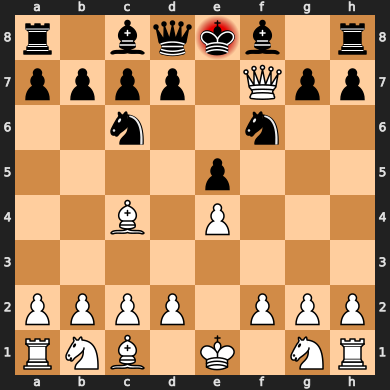

In [190]:
import chess 
board = chess.Board("r1bqkb1r/pppp1Qpp/2n2n2/4p3/2B1P3/8/PPPP1PPP/RNB1K1NR b KQkq - 0 4")
board

## Have a great day!